<center>

## Data Management and Visualization - Final Project
### Project Plan Presented in a Jupyter Notebook
#### Radu Ștefănescu, Emanuele Zoffoli, David Coderey

</center>

---

<center>

## **0) The Plan**

<center>

### Phase 1: Data Scientist Role

**1. Data Description & Quality Assessment**
- Create comprehensive data profiles for both datasets
- Document variable types, ranges, and distributions
- Calculate missing data percentages
- Identify data quality issues (outliers, inconsistencies, invalid values)
- Present summary statistics tables

**2. Exploratory Data Analysis (EDA)**
Key areas to explore:
- **Temporal patterns**: Daily ride volumes, peak hours, weekday vs weekend
- **Geographic analysis**: City-level performance differences
- **Driver performance**: Rating distributions, experience vs performance
- **Financial metrics**: Fare analysis, promo code effectiveness
- **Operational efficiency**: Distance/duration relationships, driver utilization
- **Quality metrics**: Rating patterns, driver status correlations

**3. Data Transformation & Warehouse Design**
- Design a star schema with:
  - **Fact table**: Rides (measures: fare, distance, duration, rating)
  - **Dimension tables**: Drivers, Date, City, Promo_Codes
- Create ER diagrams showing relationships
- Document transformation logic and business rules

**4. Interactive Dashboard (Tableau)**
- Operational metrics dashboard
- Driver performance analytics
- Revenue and pricing insights
- Geographic performance comparison

### Phase 2: Business Analyst Role

**Key Questions to Address:**
- What strategic insights emerge from the data?
- How can CityRide optimize operations?
- What are the limitations and data gaps?
- What recommendations support business goals?

---

<center>

## **1) Data Description & Quality Assessment**

</center>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

**DataProfiler init**
+ Load modules and set display options.
+ Create the class and define how datasets are loaded.

In [2]:
# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

class DataProfiler:
    """Comprehensive data profiling for CityRide datasets"""
    
    def __init__(self, rides_path, drivers_path):
        """Initialize with dataset paths"""
        self.rides_df = pd.read_csv(rides_path)
        self.drivers_df = pd.read_csv(drivers_path)

**DataProfiler.generate_profile_summary**
+ Prints basic dataset info (rows, columns, memory usage).
+ Analyzes each column for type, missing values, and uniqueness.
+ Computes numeric statistics (min, max, mean, median, std).
+ Identifies top category and frequency for non-numeric columns.
+ Returns a DataFrame summarizing all column-level metrics.

In [3]:
def generate_profile_summary(self, df, dataset_name):
        """Generate comprehensive profile for a dataset"""
        print(f"\n{'='*80}")
        print(f"DATA PROFILE: {dataset_name}")
        print(f"{'='*80}\n")
        
        # Basic Information
        print(f"Dataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
        print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
        print(f"\n{'-'*80}\n")
        
        # Column-by-column analysis
        profile_data = []
        
        for col in df.columns:
            col_info = {
                'Variable': col,
                'Type': str(df[col].dtype),
                'Non-Null': f"{df[col].count():,}",
                'Null': f"{df[col].isnull().sum():,}",
                'Null %': f"{(df[col].isnull().sum() / len(df) * 100):.2f}%",
                'Unique': f"{df[col].nunique():,}",
                'Unique %': f"{(df[col].nunique() / len(df) * 100):.2f}%"
            }
            
            # Add type-specific statistics
            if pd.api.types.is_numeric_dtype(df[col]):
                col_info['Min'] = f"{df[col].min():.2f}" if not df[col].isnull().all() else 'N/A'
                col_info['Max'] = f"{df[col].max():.2f}" if not df[col].isnull().all() else 'N/A'
                col_info['Mean'] = f"{df[col].mean():.2f}" if not df[col].isnull().all() else 'N/A'
                col_info['Median'] = f"{df[col].median():.2f}" if not df[col].isnull().all() else 'N/A'
                col_info['Std'] = f"{df[col].std():.2f}" if not df[col].isnull().all() else 'N/A'
            else:
                # For non-numeric, show top value
                if df[col].count() > 0:
                    top_val = df[col].mode()[0] if len(df[col].mode()) > 0 else 'N/A'
                    top_count = df[col].value_counts().iloc[0] if len(df[col].value_counts()) > 0 else 0
                    col_info['Top Value'] = str(top_val)[:30]
                    col_info['Top Freq'] = f"{top_count:,}"
                else:
                    col_info['Top Value'] = 'N/A'
                    col_info['Top Freq'] = '0'
            
            profile_data.append(col_info)
        
        profile_df = pd.DataFrame(profile_data)
        print(profile_df.to_string(index=False))
        
        return profile_df

# Assign method to class
DataProfiler.generate_profile_summary = generate_profile_summary

**DataProfiler.identify_data_quality_issues**
+ Checks each column for missing values and reports percentages.
+ Detects duplicate rows in the dataset.
+ Flags numeric outliers using the IQR rule and reports counts and ranges.
+ Returns a list summarizing all identified data quality issues.

In [4]:
def identify_data_quality_issues(self, df, dataset_name):
        """Identify potential data quality issues"""
        print(f"\n{'='*80}")
        print(f"DATA QUALITY ASSESSMENT: {dataset_name}")
        print(f"{'='*80}\n")
        
        issues = []
        
        # Check for missing values
        missing = df.isnull().sum()
        if missing.sum() > 0:
            print("⚠ MISSING VALUES DETECTED:")
            for col in missing[missing > 0].index:
                pct = (missing[col] / len(df)) * 100
                print(f"  • {col}: {missing[col]:,} ({pct:.2f}%)")
                issues.append(f"{col}: {pct:.2f}% missing")
            print()
        else:
            print("✓ No missing values detected\n")
        
        # Check for duplicates
        dupe_count = df.duplicated().sum()
        if dupe_count > 0:
            print(f"⚠ DUPLICATE ROWS: {dupe_count:,} ({(dupe_count/len(df)*100):.2f}%)\n")
            issues.append(f"Duplicate rows: {dupe_count}")
        else:
            print("✓ No duplicate rows detected\n")
        
        # Numeric columns - outlier detection using IQR method
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) > 0:
            print("OUTLIER DETECTION (IQR Method):")
            for col in numeric_cols:
                Q1 = df[col].quantile(0.25)
                Q3 = df[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
                
                if len(outliers) > 0:
                    pct = (len(outliers) / len(df)) * 100
                    print(f"  • {col}: {len(outliers):,} outliers ({pct:.2f}%)")
                    print(f"    Range: [{df[col].min():.2f}, {df[col].max():.2f}]")
                    print(f"    Expected range: [{lower_bound:.2f}, {upper_bound:.2f}]")
                    issues.append(f"{col}: {pct:.2f}% outliers")
            print()
        
        return issues

# Assign method to class
DataProfiler.identify_data_quality_issues = identify_data_quality_issues

**DataProfiler.generate_summary_statistics**
+ Selects all numeric columns from the rides and drivers datasets.
+ Generates descriptive statistics using DataFrame.describe().
+ Prints metrics including count, mean, std, min, max, and quartiles.
+ Provides a quick numeric overview for both datasets side-by-side.

In [5]:
def generate_summary_statistics(self):
    """Generate detailed summary statistics for both datasets"""
    
    print("\n" + "="*80)
    print("RIDES DATA - SUMMARY STATISTICS")
    print("="*80 + "\n")
    
    # Rides numeric summary
    rides_numeric = self.rides_df.select_dtypes(include=[np.number])
    print(rides_numeric.describe().round(2).to_string())
    
    print("\n" + "="*80)
    print("DRIVERS DATA - SUMMARY STATISTICS")
    print("="*80 + "\n")
    
    # Drivers numeric summary
    drivers_numeric = self.drivers_df.select_dtypes(include=[np.number])
    print(drivers_numeric.describe().round(2).to_string())

# Assign method to class
DataProfiler.generate_summary_statistics = generate_summary_statistics

**DataProfiler.generate_categorical_summary**
+ Identifies all categorical (object) columns in both datasets.
+ Prints the top 10 most common values for each column.
+ Shows how many additional unique values exist beyond the top 10.
+ Helps understand category distributions and dominant categories.

In [6]:
def generate_categorical_summary(self):
        """Summarize categorical variables"""
        
        print("\n" + "="*80)
        print("CATEGORICAL VARIABLES SUMMARY")
        print("="*80 + "\n")
        
        # Rides categorical
        print("RIDES DATA:")
        print("-" * 40)
        categorical_cols = self.rides_df.select_dtypes(include=['object']).columns
        for col in categorical_cols:
            print(f"\n{col}:")
            value_counts = self.rides_df[col].value_counts()
            print(value_counts.head(10).to_string())
            if len(value_counts) > 10:
                print(f"  ... and {len(value_counts) - 10} more unique values")
        
        # Drivers categorical
        print("\n\nDRIVERS DATA:")
        print("-" * 40)
        categorical_cols = self.drivers_df.select_dtypes(include=['object']).columns
        for col in categorical_cols:
            print(f"\n{col}:")
            value_counts = self.drivers_df[col].value_counts()
            print(value_counts.head(10).to_string())
            if len(value_counts) > 10:
                print(f"  ... and {len(value_counts) - 10} more unique values")

# Assign method to class
DataProfiler.generate_categorical_summary = generate_categorical_summary

**DataProfiler.generate_relationship_analysis**
+ Compares Driver_ID values between rides and drivers datasets.
+ Counts drivers with rides, drivers without rides, and unmatched ride records.
+ Warns about orphaned rides (missing driver info).
+ Computes ride distribution per driver (mean, median, min, max, std).
+ Provides an overview of dataset consistency and driver activity.

In [7]:
def generate_relationship_analysis(self):
        """Analyze relationships between datasets"""
        print("\n" + "="*80)
        print("DATASET RELATIONSHIP ANALYSIS")
        print("="*80 + "\n")
        
        # Check Driver_ID overlap
        rides_drivers = set(self.rides_df['Driver_ID'].unique())
        all_drivers = set(self.drivers_df['Driver_ID'].unique())
        
        print(f"Total Drivers in Drivers table: {len(all_drivers):,}")
        print(f"Unique Drivers with rides: {len(rides_drivers):,}")
        print(f"Drivers without rides: {len(all_drivers - rides_drivers):,}")
        print(f"Driver_ID overlap: {(len(rides_drivers) / len(all_drivers) * 100):.2f}%")
        
        # Check for orphaned rides (rides without driver info)
        orphaned = rides_drivers - all_drivers
        if orphaned:
            print(f"\n⚠ WARNING: {len(orphaned)} Driver IDs in Rides table not found in Drivers table")
        else:
            print("\n✓ All rides have corresponding driver records")
        
        # Rides per driver statistics
        rides_per_driver = self.rides_df.groupby('Driver_ID').size()
        print(f"\nRides per Driver Statistics:")
        print(f"  Mean: {rides_per_driver.mean():.2f}")
        print(f"  Median: {rides_per_driver.median():.0f}")
        print(f"  Min: {rides_per_driver.min()}")
        print(f"  Max: {rides_per_driver.max()}")
        print(f"  Std: {rides_per_driver.std():.2f}")

# Assign method to class
DataProfiler.generate_relationship_analysis = generate_relationship_analysis

**DataProfiler.generate_full_report**
+ Generates full column-level profiles for both datasets.
+ Runs data-quality checks (missing values, duplicates, outliers).
+ Produces numeric summary statistics and categorical summaries.
+ Analyzes relationships between rides and drivers (ID overlap, ride counts).
+ Prints a complete formatted report with timestamps and summary metrics.
+ Returns all generated results in a structured dictionary.

In [8]:
def generate_full_report(self):
        """Generate complete data profiling report"""
        print("\n")
        print("█" * 80)
        print(" " * 20 + "CITYRIDE DATA PROFILING REPORT")
        print(" " * 25 + f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        print("█" * 80)
        
        # Profile both datasets
        rides_profile = self.generate_profile_summary(self.rides_df, "RIDES DATA")
        drivers_profile = self.generate_profile_summary(self.drivers_df, "DRIVERS DATA")
        
        # Data quality assessment
        rides_issues = self.identify_data_quality_issues(self.rides_df, "RIDES DATA")
        drivers_issues = self.identify_data_quality_issues(self.drivers_df, "DRIVERS DATA")
        
        # Summary statistics
        self.generate_summary_statistics()
        
        # Categorical summary
        self.generate_categorical_summary()
        
        # Relationship analysis
        self.generate_relationship_analysis()
        
        # Final summary
        print("\n" + "="*80)
        print("PROFILING SUMMARY")
        print("="*80 + "\n")
        print(f"Total Rides Analyzed: {len(self.rides_df):,}")
        print(f"Total Drivers Analyzed: {len(self.drivers_df):,}")
        print(f"Data Quality Issues Found: {len(rides_issues) + len(drivers_issues)}")
        print(f"\nReport Generation Complete!")
        print("="*80 + "\n")
        
        return {
            'rides_profile': rides_profile,
            'drivers_profile': drivers_profile,
            'rides_issues': rides_issues,
            'drivers_issues': drivers_issues
        }

# Assign method to class
DataProfiler.generate_full_report = generate_full_report

**Using DataProfiler**
+ Creates a DataProfiler instance with the paths to the raw CSV files.
+ Executes the full profiling workflow and stores all results.
+ Includes optional lines for saving profile summaries to CSV for reporting.

In [9]:
# USAGE EXAMPLE
if __name__ == "__main__":
    # Initialize profiler with your data paths
    profiler = DataProfiler('../0_raw_data/Rides_Data.csv', '../0_raw_data/Drivers_Data.csv')
    
    # Generate complete profiling report
    results = profiler.generate_full_report()
    
    # Optional: Save profiles to CSV for reporting
    # results['rides_profile'].to_csv('rides_profile_summary.csv', index=False)
    # results['drivers_profile'].to_csv('drivers_profile_summary.csv', index=False)



████████████████████████████████████████████████████████████████████████████████
                    CITYRIDE DATA PROFILING REPORT
                         Generated: 2025-12-14 17:23:24
████████████████████████████████████████████████████████████████████████████████

DATA PROFILE: RIDES DATA

Dataset Shape: 1,000 rows × 9 columns
Memory Usage: 0.20 MB

--------------------------------------------------------------------------------

    Variable    Type Non-Null Null Null % Unique Unique %    Min     Max   Mean Median    Std   Top Value Top Freq
     Ride_ID   int64    1,000    0  0.00%  1,000  100.00%   1.00 1000.00 500.50 500.50 288.82         NaN      NaN
   Driver_ID   int64    1,000    0  0.00%    100   10.00% 101.00  200.00 150.50 149.00  28.96         NaN      NaN
        City  object    1,000    0  0.00%      5    0.50%    NaN     NaN    NaN    NaN    NaN Los Angeles      221
        Date  object    1,000    0  0.00%     30    3.00%    NaN     NaN    NaN    NaN    NaN  11/3

---

<center>

## **2) Data Cleaning & Feature Engineering**

</center>

**DataTransformer init**
+ Receives the raw rides and drivers DataFrames (typically coming from the DataProfiler).
+ Creates separate internal copies to ensure the original data isn’t modified.
+ Sets up a placeholder merged_df attribute, which will later store the combined rides–drivers dataset after transformation.
+ Establishes a clean starting point for running all transformation steps (promo features, derived metrics, temporal features, merging).

In [10]:
class DataTransformer:
    """Clean and transform CityRide datasets before EDA."""
    
    def __init__(self, rides_df, drivers_df):
        self.rides_df = rides_df.copy()
        self.drivers_df = drivers_df.copy()
        self.merged_df = None

**DataTransformer.add_promo_features**
+ Cleans the Promo_Code column by replacing missing values with "NO_PROMO".
+ Creates a binary flag Has_Promo indicating whether a promo code was applied to the ride.
+ Extracts the numeric discount value from promo codes (e.g., "PROMO20" → 0.20) and stores it in Promo_Discount.
+ Ensures all promo-related calculations are robust even when promo codes are missing or non-numeric.

In [11]:
def add_promo_features(self):
    """Add promo-related engineered features."""
    
    # Normalize missing promo codes
    self.rides_df['Promo_Code'] = self.rides_df['Promo_Code'].fillna('NO_PROMO')
    
    # Flag if promo code is used
    self.rides_df['Has_Promo'] = (self.rides_df['Promo_Code'] != 'NO_PROMO').astype(int)
    
    # Extract numeric discount (safe even for NO_PROMO)
    self.rides_df['Promo_Discount'] = (
        self.rides_df['Promo_Code']
            .str.extract(r'(\d+)', expand=False)
            .astype(float)
            .fillna(0) / 100
    )
    
    print("✓ Added promo feature columns: Has_Promo, Promo_Discount")

# Assign method to class
DataTransformer.add_promo_features = add_promo_features

**DataTransformer.add_derived_metrics**
+ Creates Fare_per_km, a normalized cost metric showing how much each ride costs per kilometer.
+ Calculates Speed_kmh, an estimated average ride speed based on distance and duration.
+ Enhances the dataset with additional performance-related metrics that support deeper EDA and operational analysis.

In [12]:
def add_derived_metrics(self):
    """Add engineered ride-level metrics."""
    
    self.rides_df['Fare_per_km'] = self.rides_df['Fare'] / self.rides_df['Distance_km']
    self.rides_df['Speed_kmh'] = (
        self.rides_df['Distance_km'] / self.rides_df['Duration_min']
    ) * 60
    
    print("✓ Added derived metrics: Fare_per_km, Speed_kmh")
    
# Assign method to class
DataTransformer.add_derived_metrics = add_derived_metrics

**DataTransformer.add_temporal_features**
+ Converts the Date column into a proper datetime format for reliable time-based analysis.
+ Extracts useful temporal features such as day of week, week number, and day of month.
+ Creates an Is_Weekend flag to distinguish weekend vs. weekday rides.
+ Enriches the dataset with time-related insights that support trend, seasonality, and usage-pattern analysis.

In [13]:
def add_temporal_features(self):
    """Add datetime-based engineered features."""
    
    self.rides_df['Date'] = pd.to_datetime(self.rides_df['Date'])
    self.rides_df['Day_of_Week'] = self.rides_df['Date'].dt.day_name()
    self.rides_df['Week_Number'] = self.rides_df['Date'].dt.isocalendar().week
    self.rides_df['Day_of_Month'] = self.rides_df['Date'].dt.day
    self.rides_df['Is_Weekend'] = (
        self.rides_df['Date'].dt.dayofweek.isin([5, 6]).astype(int)
    )
    
    print("✓ Added temporal features: Day_of_Week, Week_Number, Day_of_Month, Is_Weekend")

# Assign method to class
DataTransformer.add_temporal_features = add_temporal_features

**DataTransformer.merge_datasets**
+ Combines the rides and drivers data into a single enriched dataset using Driver_ID as the key.
+ Performs a left join, ensuring every ride keeps its record even if driver details are missing.
+ Adds suffixes (_ride, _driver) to prevent column name conflicts.
+ Produces merged_df, the unified dataset required for deeper EDA, performance analysis, and driver-level insights.

In [14]:
def merge_datasets(self):
    """Merge rides + drivers for enriched analysis."""
    
    self.merged_df = self.rides_df.merge(
        self.drivers_df,
        on='Driver_ID',
        how='left',
        suffixes=('_ride', '_driver')
    )
    
    print(f"✓ Merged datasets → {len(self.merged_df):,} records")

# Assign method to class
DataTransformer.merge_datasets = merge_datasets

**DataTransformer.transform_all and Using DataTransformer**
+ Executes the entire transformation pipeline in the correct order.
+ Adds promo-related features (Has_Promo, Promo_Discount).
+ Adds engineered ride metrics (Fare_per_km, Speed_kmh).
+ Adds temporal features (day, week number, weekend flag).
+ Merges rides + drivers into a final enriched dataset (merged_df).
+ Returns all cleaned datasets so EDA can run directly on fully processed data.

In [15]:
def transform_all(self):
        """Run full transformation pipeline."""
        print("\n🚧 Transforming datasets...")
        print("=" * 80)

        self.add_promo_features()
        self.add_derived_metrics()
        self.add_temporal_features()
        self.merge_datasets()
        
        print("\n✨ Transformation complete!")
        print("=" * 80)

        return self.rides_df, self.drivers_df, self.merged_df

# Assign method to class
DataTransformer.transform_all = transform_all

# USAGE EXAMPLE
if __name__ == "__main__":
    transformer = DataTransformer(profiler.rides_df, profiler.drivers_df)
    rides_clean, drivers_clean, merged_clean = transformer.transform_all()


🚧 Transforming datasets...
✓ Added promo feature columns: Has_Promo, Promo_Discount
✓ Added derived metrics: Fare_per_km, Speed_kmh
✓ Added temporal features: Day_of_Week, Week_Number, Day_of_Month, Is_Weekend
✓ Merged datasets → 1,000 records

✨ Transformation complete!


<center>

## **3) Exploratory Data Analysis with Visualizations**

</center>

**CityRideEDA init**
+ Accepts already-cleaned and transformed versions of the rides, drivers, and merged datasets.
+ Stores separate copies of each dataframe to prevent accidental modification.
+ Prepares all three datasets for downstream EDA methods (visualizations, summaries, correlations, etc.).
+ Confirms successful initialization so the EDA workflow can run smoothly.

In [16]:
# Set style for professional visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

class CityRideEDA:
    def __init__(self, rides_df, drivers_df, merged_df):
        self.rides_df = rides_df.copy()
        self.drivers_df = drivers_df.copy()
        self.merged_df = merged_df.copy()

        print("✓ EDA initialized with transformed + merged datasets")

**CityRideEDA.temporal_analysis**
+ Analyzes daily ride volume and overlays trend lines.
+ Compares ride counts across days of the week, highlighting weekends.
+ Compares weekday vs weekend performance using normalized metrics (ride count, fare, distance, rating).
+ Plots total daily revenue with average revenue reference line.
+ Saves the full visualization as a PNG.
+ Prints high-level temporal insights (busiest day, slowest day, revenue averages, etc.).

In [17]:
def temporal_analysis(self):
        """Analyze temporal patterns in ride data"""
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Temporal Analysis: Ride Patterns Over Time', fontsize=16, fontweight='bold')
        
        # 1. Daily ride volume
        daily_rides = self.rides_df.groupby('Date').size()
        axes[0, 0].plot(daily_rides.index, daily_rides.values, marker='o', linewidth=2, markersize=4)
        axes[0, 0].set_title('Daily Ride Volume', fontweight='bold', fontsize=12)
        axes[0, 0].set_xlabel('Date')
        axes[0, 0].set_ylabel('Number of Rides')
        axes[0, 0].grid(True, alpha=0.3)
        axes[0, 0].tick_params(axis='x', rotation=45)
        
        # Add trend line
        z = np.polyfit(range(len(daily_rides)), daily_rides.values, 1)
        p = np.poly1d(z)
        axes[0, 0].plot(daily_rides.index, p(range(len(daily_rides))), 
                       "r--", alpha=0.8, linewidth=2, label='Trend')
        axes[0, 0].legend()
        
        # 2. Day of week comparison
        dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        dow_data = self.rides_df['Day_of_Week'].value_counts().reindex(dow_order)
        colors = ['#ff6b6b' if day in ['Saturday', 'Sunday'] else '#4ecdc4' for day in dow_order]
        axes[0, 1].bar(range(len(dow_data)), dow_data.values, color=colors, edgecolor='black', linewidth=1.2)
        axes[0, 1].set_title('Rides by Day of Week', fontweight='bold', fontsize=12)
        axes[0, 1].set_xlabel('Day of Week')
        axes[0, 1].set_ylabel('Number of Rides')
        axes[0, 1].set_xticks(range(len(dow_order)))
        axes[0, 1].set_xticklabels(dow_order, rotation=45, ha='right')
        axes[0, 1].grid(True, alpha=0.3, axis='y')
        
        # Add value labels
        for i, v in enumerate(dow_data.values):
            axes[0, 1].text(i, v + 50, str(v), ha='center', va='bottom', fontweight='bold')
        
        # 3. Weekend vs Weekday comparison
        weekend_comp = self.rides_df.groupby('Is_Weekend').agg({
            'Ride_ID': 'count',
            'Fare': 'mean',
            'Distance_km': 'mean',
            'Rating': 'mean'
        }).round(2)
        weekend_comp.index = ['Weekday', 'Weekend']
        
        x = np.arange(len(weekend_comp.columns))
        width = 0.35
        
        # Normalize for better visualization
        normalized_data = weekend_comp.copy()
        for col in normalized_data.columns:
            max_val = normalized_data[col].max()
            normalized_data[col] = (normalized_data[col] / max_val) * 100
        
        axes[1, 0].bar(x - width/2, normalized_data.iloc[0], width, label='Weekday', color='#4ecdc4', edgecolor='black')
        axes[1, 0].bar(x + width/2, normalized_data.iloc[1], width, label='Weekend', color='#ff6b6b', edgecolor='black')
        axes[1, 0].set_title('Weekend vs Weekday Performance (Normalized)', fontweight='bold', fontsize=12)
        axes[1, 0].set_ylabel('Normalized Score (%)')
        axes[1, 0].set_xticks(x)
        axes[1, 0].set_xticklabels(['Ride Count', 'Avg Fare', 'Avg Distance', 'Avg Rating'], rotation=45, ha='right')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3, axis='y')
        
        # 4. Daily revenue trend
        daily_revenue = self.rides_df.groupby('Date')['Fare'].sum()
        axes[1, 1].fill_between(daily_revenue.index, daily_revenue.values, alpha=0.3, color='green')
        axes[1, 1].plot(daily_revenue.index, daily_revenue.values, marker='o', linewidth=2, 
                       markersize=4, color='darkgreen')
        axes[1, 1].set_title('Daily Revenue Trend', fontweight='bold', fontsize=12)
        axes[1, 1].set_xlabel('Date')
        axes[1, 1].set_ylabel('Total Revenue ($)')
        axes[1, 1].grid(True, alpha=0.3)
        axes[1, 1].tick_params(axis='x', rotation=45)
        
        # Add average line
        avg_revenue = daily_revenue.mean()
        axes[1, 1].axhline(y=avg_revenue, color='red', linestyle='--', 
                          linewidth=2, label=f'Avg: ${avg_revenue:,.0f}')
        axes[1, 1].legend()
        
        plt.tight_layout()
        plt.savefig('temporal_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Print insights
        print("\n" + "="*80)
        print("TEMPORAL INSIGHTS")
        print("="*80)
        print(f"\n1. Busiest day: {dow_data.idxmax()} with {dow_data.max():,} rides")
        print(f"2. Slowest day: {dow_data.idxmin()} with {dow_data.min():,} rides")
        print(f"3. Weekend vs Weekday rides: {dow_data[['Saturday', 'Sunday']].sum():,} vs {dow_data[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']].sum():,}")
        print(f"4. Average daily rides: {daily_rides.mean():.0f}")
        print(f"5. Average daily revenue: ${daily_revenue.mean():,.2f}")

# Assign method to class
CityRideEDA.temporal_analysis = temporal_analysis

**CityRideEDA.geographic_analysis**
+ Compares cities by ride volume using a horizontal bar chart.
+ Shows average fare differences across cities.
+ Visualizes each city's revenue contribution via a pie chart.
+ Builds a heatmap of normalized performance metrics (fare, distance, duration, rating, fare per km).
+ Saves the full figure as a PNG.
+ Prints high-level insights: top city by volume, revenue, average fare, and market share of the top three cities.

In [18]:
def geographic_analysis(self):
        """Analyze performance across different cities"""
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Geographic Analysis: City Performance Comparison', fontsize=16, fontweight='bold')
        
        # 1. Rides by city
        city_rides = self.rides_df['City'].value_counts()
        axes[0, 0].barh(range(len(city_rides)), city_rides.values, color=sns.color_palette("viridis", len(city_rides)))
        axes[0, 0].set_yticks(range(len(city_rides)))
        axes[0, 0].set_yticklabels(city_rides.index)
        axes[0, 0].set_title('Ride Volume by City', fontweight='bold', fontsize=12)
        axes[0, 0].set_xlabel('Number of Rides')
        axes[0, 0].grid(True, alpha=0.3, axis='x')
        
        # Add value labels
        for i, v in enumerate(city_rides.values):
            axes[0, 0].text(v + 50, i, f'{v:,}', va='center', fontweight='bold')
        
        # 2. Average fare by city
        city_fare = self.rides_df.groupby('City')['Fare'].mean().sort_values(ascending=False)
        axes[0, 1].barh(range(len(city_fare)), city_fare.values, color=sns.color_palette("rocket", len(city_fare)))
        axes[0, 1].set_yticks(range(len(city_fare)))
        axes[0, 1].set_yticklabels(city_fare.index)
        axes[0, 1].set_title('Average Fare by City', fontweight='bold', fontsize=12)
        axes[0, 1].set_xlabel('Average Fare ($)')
        axes[0, 1].grid(True, alpha=0.3, axis='x')
        
        for i, v in enumerate(city_fare.values):
            axes[0, 1].text(v + 0.5, i, f'${v:.2f}', va='center', fontweight='bold')
        
        # 3. City revenue contribution
        city_revenue = self.rides_df.groupby('City')['Fare'].sum().sort_values(ascending=False)
        colors_pie = sns.color_palette("Set2", len(city_revenue))
        wedges, texts, autotexts = axes[1, 0].pie(city_revenue.values, labels=city_revenue.index, 
                                                   autopct='%1.1f%%', startangle=90, colors=colors_pie,
                                                   textprops={'fontsize': 10, 'fontweight': 'bold'})
        axes[1, 0].set_title('Revenue Contribution by City', fontweight='bold', fontsize=12)
        
        # 4. City metrics heatmap
        city_metrics = self.rides_df.groupby('City').agg({
            'Fare': 'mean',
            'Distance_km': 'mean',
            'Duration_min': 'mean',
            'Rating': 'mean',
            'Fare_per_km': 'mean'
        }).round(2)
        
        # Normalize for heatmap
        city_metrics_norm = (city_metrics - city_metrics.min()) / (city_metrics.max() - city_metrics.min())
        
        sns.heatmap(city_metrics_norm.T, annot=city_metrics.T, fmt='.2f', cmap='YlOrRd', 
                   cbar_kws={'label': 'Normalized Score'}, ax=axes[1, 1], linewidths=0.5)
        axes[1, 1].set_title('City Performance Heatmap', fontweight='bold', fontsize=12)
        axes[1, 1].set_xlabel('City')
        axes[1, 1].set_ylabel('Metrics')
        
        plt.tight_layout()
        plt.savefig('geographic_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Print insights
        print("\n" + "="*80)
        print("GEOGRAPHIC INSIGHTS")
        print("="*80)
        print(f"\n1. Highest volume city: {city_rides.idxmax()} with {city_rides.max():,} rides")
        print(f"2. Highest revenue city: {city_revenue.idxmax()} with ${city_revenue.max():,.2f}")
        print(f"3. Highest avg fare: {city_fare.idxmax()} at ${city_fare.max():.2f}")
        print(f"4. City market share (top 3):")
        for i, (city, revenue) in enumerate(city_revenue.head(3).items(), 1):
            pct = (revenue / city_revenue.sum()) * 100
            print(f"   {i}. {city}: ${revenue:,.2f} ({pct:.1f}%)")

# Assign method to class
CityRideEDA.geographic_analysis = geographic_analysis

**CityRideEDA.driver_performance_analysis**
+ Visualizes the relationship between driver experience and ratings with a scatter plot and trend line.
+ Shows driver age distribution with mean and median markers.
+ Summarizes active vs inactive driver counts with annotated bars.
+ Displays distribution of rides per driver, highlighting mean and median.
+ Shows average driver rating distribution.
+ Identifies and plots the top 10 revenue-generating drivers.
+ Saves the visualization as a PNG and prints key insights (e.g., most productive driver, rating averages, active driver totals).

In [19]:
def driver_performance_analysis(self):
    """Analyze driver performance and characteristics"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Driver Performance Analysis', fontsize=16, fontweight='bold')
    
    # 1. Experience vs Average Rating
    exp_rating = self.drivers_df.groupby('Experience_Years')['Average_Rating'].mean()
    axes[0, 0].scatter(self.drivers_df['Experience_Years'], self.drivers_df['Average_Rating'], 
                      alpha=0.5, s=50, color='steelblue')
    axes[0, 0].plot(exp_rating.index, exp_rating.values, color='red', linewidth=3, label='Mean Rating')
    axes[0, 0].set_title('Experience vs Driver Rating', fontweight='bold', fontsize=12)
    axes[0, 0].set_xlabel('Years of Experience')
    axes[0, 0].set_ylabel('Average Rating')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Age distribution
    axes[0, 1].hist(self.drivers_df['Age'], bins=20, color='coral', edgecolor='black', alpha=0.7)
    axes[0, 1].axvline(self.drivers_df['Age'].mean(), color='red', linestyle='--', 
                      linewidth=2, label=f'Mean: {self.drivers_df["Age"].mean():.1f}')
    axes[0, 1].axvline(self.drivers_df['Age'].median(), color='green', linestyle='--', 
                      linewidth=2, label=f'Median: {self.drivers_df["Age"].median():.1f}')
    axes[0, 1].set_title('Driver Age Distribution', fontweight='bold', fontsize=12)
    axes[0, 1].set_xlabel('Age')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    
    # 3. Active vs Inactive drivers
    status_counts = self.drivers_df['Active_Status'].value_counts()
    colors_status = ['#2ecc71', '#e74c3c']
    axes[0, 2].bar(status_counts.index, status_counts.values, color=colors_status, 
                  edgecolor='black', linewidth=1.5)
    axes[0, 2].set_title('Driver Active Status', fontweight='bold', fontsize=12)
    axes[0, 2].set_ylabel('Number of Drivers')
    axes[0, 2].grid(True, alpha=0.3, axis='y')
    
    for i, v in enumerate(status_counts.values):
        axes[0, 2].text(i, v + 5, f'{v:,}\n({v/status_counts.sum()*100:.1f}%)', 
                       ha='center', va='bottom', fontweight='bold')
    
    # 4. Rides per driver distribution
    rides_per_driver = self.rides_df.groupby('Driver_ID').size()
    axes[1, 0].hist(rides_per_driver.values, bins=30, color='mediumpurple', 
                   edgecolor='black', alpha=0.7)
    axes[1, 0].axvline(rides_per_driver.mean(), color='red', linestyle='--', 
                      linewidth=2, label=f'Mean: {rides_per_driver.mean():.1f}')
    axes[1, 0].axvline(rides_per_driver.median(), color='green', linestyle='--', 
                      linewidth=2, label=f'Median: {rides_per_driver.median():.1f}')
    axes[1, 0].set_title('Rides per Driver Distribution', fontweight='bold', fontsize=12)
    axes[1, 0].set_xlabel('Number of Rides')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # 5. Driver rating distribution
    axes[1, 1].hist(self.drivers_df['Average_Rating'], bins=20, color='gold', 
                   edgecolor='black', alpha=0.7)
    axes[1, 1].axvline(self.drivers_df['Average_Rating'].mean(), color='red', 
                      linestyle='--', linewidth=2, label=f'Mean: {self.drivers_df["Average_Rating"].mean():.2f}')
    axes[1, 1].set_title('Driver Rating Distribution', fontweight='bold', fontsize=12)
    axes[1, 1].set_xlabel('Average Rating')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    # 6. Top performing drivers
    driver_performance = self.merged_df.groupby('Driver_ID').agg({
        'Ride_ID': 'count',
        'Fare': 'sum',
        'Rating': 'mean'
    }).round(2)
    driver_performance = driver_performance.rename(columns={
        'Ride_ID': 'Total_Rides',
        'Fare': 'Total_Revenue',
        'Rating': 'Avg_Rating'
    })
    top_drivers = driver_performance.nlargest(10, 'Total_Revenue')
    
    axes[1, 2].barh(range(len(top_drivers)), top_drivers['Total_Revenue'].values, 
                   color=sns.color_palette("plasma", len(top_drivers)))
    axes[1, 2].set_yticks(range(len(top_drivers)))
    axes[1, 2].set_yticklabels([f'Driver {id}' for id in top_drivers.index])
    axes[1, 2].set_title('Top 10 Drivers by Revenue', fontweight='bold', fontsize=12)
    axes[1, 2].set_xlabel('Total Revenue ($)')
    axes[1, 2].grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.savefig('driver_performance_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print insights
    print("\n" + "="*80)
    print("DRIVER PERFORMANCE INSIGHTS")
    print("="*80)
    print(f"\n1. Total active drivers: {status_counts.get('Active', 0):,}")
    print(f"2. Total inactive drivers: {status_counts.get('Inactive', 0):,}")
    print(f"3. Average rides per driver: {rides_per_driver.mean():.1f}")
    print(f"4. Most productive driver: {rides_per_driver.idxmax()} with {rides_per_driver.max()} rides")
    print(f"5. Average driver rating: {self.drivers_df['Average_Rating'].mean():.2f}")
    print(f"6. Drivers with rating < 4.0: {(self.drivers_df['Average_Rating'] < 4.0).sum()}")

# Assign method to class
CityRideEDA.driver_performance_analysis = driver_performance_analysis

**CityRideEDA.financial_analysis**
+ Visualizes fare distribution with mean/median indicators.
+ Plots distance vs. fare with a regression line and correlation value.
+ Shows distribution of fare-per-kilometer.
+ Compares promo vs. non-promo performance using normalized metrics.
+ Highlights top promo codes by revenue.
+ Shows daily revenue and cumulative revenue trends with dual axes.
+ Saves the full figure as a PNG.
+ Prints key financial insights: total revenue, average fare, fare per km, promo usage rate, promo revenue, and average daily revenue.

In [20]:
def financial_analysis(self):
        """Analyze financial metrics and pricing"""
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Financial Analysis: Revenue and Pricing Insights', fontsize=16, fontweight='bold')
        
        # 1. Fare distribution
        axes[0, 0].hist(self.rides_df['Fare'], bins=50, color='lightgreen', 
                       edgecolor='black', alpha=0.7)
        axes[0, 0].axvline(self.rides_df['Fare'].mean(), color='red', linestyle='--', 
                          linewidth=2, label=f'Mean: ${self.rides_df["Fare"].mean():.2f}')
        axes[0, 0].axvline(self.rides_df['Fare'].median(), color='blue', linestyle='--', 
                          linewidth=2, label=f'Median: ${self.rides_df["Fare"].median():.2f}')
        axes[0, 0].set_title('Fare Distribution', fontweight='bold', fontsize=12)
        axes[0, 0].set_xlabel('Fare ($)')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3, axis='y')
        
        # 2. Distance vs Fare scatter
        axes[0, 1].scatter(self.rides_df['Distance_km'], self.rides_df['Fare'], 
                          alpha=0.4, s=20, color='navy')
        
        # Add regression line
        z = np.polyfit(self.rides_df['Distance_km'], self.rides_df['Fare'], 1)
        p = np.poly1d(z)
        axes[0, 1].plot(self.rides_df['Distance_km'], 
                       p(self.rides_df['Distance_km']), 
                       "r-", linewidth=3, label=f'y={z[0]:.2f}x+{z[1]:.2f}')
        axes[0, 1].set_title('Distance vs Fare Relationship', fontweight='bold', fontsize=12)
        axes[0, 1].set_xlabel('Distance (km)')
        axes[0, 1].set_ylabel('Fare ($)')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # Calculate correlation
        corr = self.rides_df[['Distance_km', 'Fare']].corr().iloc[0, 1]
        axes[0, 1].text(0.05, 0.95, f'Correlation: {corr:.3f}', 
                       transform=axes[0, 1].transAxes, fontsize=10, 
                       verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        # 3. Fare per km distribution
        axes[0, 2].hist(self.rides_df['Fare_per_km'], bins=50, color='orange', 
                       edgecolor='black', alpha=0.7)
        axes[0, 2].axvline(self.rides_df['Fare_per_km'].mean(), color='red', linestyle='--', 
                          linewidth=2, label=f'Mean: ${self.rides_df["Fare_per_km"].mean():.2f}/km')
        axes[0, 2].set_title('Fare per Kilometer Distribution', fontweight='bold', fontsize=12)
        axes[0, 2].set_xlabel('Fare per km ($)')
        axes[0, 2].set_ylabel('Frequency')
        axes[0, 2].legend()
        axes[0, 2].grid(True, alpha=0.3, axis='y')
        
        # 4. Promo code impact
        promo_impact = self.rides_df.groupby('Has_Promo').agg({
            'Fare': 'mean',
            'Distance_km': 'mean',
            'Rating': 'mean',
            'Ride_ID': 'count'
        }).round(2)
        
        # Map index values to readable labels
        promo_impact.index = promo_impact.index.map({0: 'No Promo', 1: 'With Promo'})
        
        # Only plot if we have data
        if len(promo_impact) > 0:
            x = np.arange(len(promo_impact.columns))
            width = 0.35 if len(promo_impact) == 2 else 0.5
            
            # Normalize for visualization
            normalized = promo_impact.copy()
            for col in normalized.columns:
                normalized[col] = (normalized[col] / normalized[col].max()) * 100
            
            if len(promo_impact) == 2:
                axes[1, 0].bar(x - width/2, normalized.iloc[0], width, label=normalized.index[0], 
                              color='lightcoral', edgecolor='black')
                axes[1, 0].bar(x + width/2, normalized.iloc[1], width, label=normalized.index[1], 
                              color='lightblue', edgecolor='black')
            else:
                # Only one category exists
                axes[1, 0].bar(x, normalized.iloc[0], width, label=normalized.index[0], 
                              color='lightblue', edgecolor='black')
            
            axes[1, 0].set_title('Promo Code Impact (Normalized)', fontweight='bold', fontsize=12)
            axes[1, 0].set_ylabel('Normalized Score (%)')
            axes[1, 0].set_xticks(x)
            axes[1, 0].set_xticklabels(['Avg Fare', 'Avg Distance', 'Avg Rating', 'Ride Count'], 
                                       rotation=45, ha='right')
            axes[1, 0].legend()
            axes[1, 0].grid(True, alpha=0.3, axis='y')
        else:
            axes[1, 0].text(0.5, 0.5, 'No Promo Data Available', 
                           ha='center', va='center', transform=axes[1, 0].transAxes, fontsize=12)
        
        # 5. Revenue by promo code type
        promo_revenue = self.rides_df[self.rides_df['Promo_Code'] != 'NO_PROMO'].groupby('Promo_Code')['Fare'].sum().sort_values(ascending=False).head(10)
        
        if len(promo_revenue) > 0:
            axes[1, 1].barh(range(len(promo_revenue)), promo_revenue.values, 
                           color=sns.color_palette("coolwarm", len(promo_revenue)))
            axes[1, 1].set_yticks(range(len(promo_revenue)))
            axes[1, 1].set_yticklabels(promo_revenue.index)
            axes[1, 1].set_title('Top 10 Promo Codes by Revenue', fontweight='bold', fontsize=12)
            axes[1, 1].set_xlabel('Total Revenue ($)')
            axes[1, 1].grid(True, alpha=0.3, axis='x')
        else:
            axes[1, 1].text(0.5, 0.5, 'No Promo Data Available', 
                           ha='center', va='center', transform=axes[1, 1].transAxes, fontsize=12)
        
        # 6. Revenue trends
        daily_revenue = self.rides_df.groupby('Date')['Fare'].sum()
        cumulative_revenue = daily_revenue.cumsum()
        
        ax1 = axes[1, 2]
        ax2 = ax1.twinx()
        
        ax1.bar(daily_revenue.index, daily_revenue.values, alpha=0.6, color='green', label='Daily Revenue')
        ax2.plot(cumulative_revenue.index, cumulative_revenue.values, color='darkblue', 
                linewidth=3, marker='o', markersize=4, label='Cumulative Revenue')
        
        ax1.set_title('Revenue Trends', fontweight='bold', fontsize=12)
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Daily Revenue ($)', color='green')
        ax2.set_ylabel('Cumulative Revenue ($)', color='darkblue')
        ax1.tick_params(axis='y', labelcolor='green')
        ax2.tick_params(axis='y', labelcolor='darkblue')
        ax1.tick_params(axis='x', rotation=45)
        ax1.grid(True, alpha=0.3)
        
        # Combine legends
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
        
        plt.tight_layout()
        plt.savefig('financial_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Print insights
        print("\n" + "="*80)
        print("FINANCIAL INSIGHTS")
        print("="*80)
        total_revenue = self.rides_df['Fare'].sum()
        print(f"\n1. Total revenue: ${total_revenue:,.2f}")
        print(f"2. Average fare: ${self.rides_df['Fare'].mean():.2f}")
        print(f"3. Average fare per km: ${self.rides_df['Fare_per_km'].mean():.2f}")
        print(f"4. Rides with promo codes: {self.rides_df['Has_Promo'].sum():,} ({self.rides_df['Has_Promo'].mean()*100:.1f}%)")
        print(f"5. Revenue from promo rides: ${self.rides_df[self.rides_df['Has_Promo']==1]['Fare'].sum():,.2f}")
        print(f"6. Average daily revenue: ${daily_revenue.mean():,.2f}")

# Assign method to class
CityRideEDA.financial_analysis = financial_analysis

**CityRideEDA.operational_analysis**
+ Plots distributions for ride distance, duration, and average speed with mean/median indicators.
+ Analyzes the relationship between distance and duration, including regression line and correlation.
+ Visualizes customer rating distribution with colored bars and percentage labels.
+ Compares city efficiency on metrics like speed, fare-per-km, rating, and duration using a normalized heatmap.
+ Saves the full visualization as a PNG.
+ Prints operational insights: average distance, duration, speed, overall rating, and percentage of high/low ratings.

In [21]:
def operational_analysis(self):
        """Analyze operational efficiency metrics"""
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Operational Analysis: Efficiency and Performance Metrics', fontsize=16, fontweight='bold')
        
        # 1. Distance distribution
        axes[0, 0].hist(self.rides_df['Distance_km'], bins=50, color='skyblue', 
                       edgecolor='black', alpha=0.7)
        axes[0, 0].axvline(self.rides_df['Distance_km'].mean(), color='red', linestyle='--', 
                          linewidth=2, label=f'Mean: {self.rides_df["Distance_km"].mean():.2f} km')
        axes[0, 0].axvline(self.rides_df['Distance_km'].median(), color='green', linestyle='--', 
                          linewidth=2, label=f'Median: {self.rides_df["Distance_km"].median():.2f} km')
        axes[0, 0].set_title('Ride Distance Distribution', fontweight='bold', fontsize=12)
        axes[0, 0].set_xlabel('Distance (km)')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3, axis='y')
        
        # 2. Duration distribution
        axes[0, 1].hist(self.rides_df['Duration_min'], bins=50, color='lightcoral', 
                       edgecolor='black', alpha=0.7)
        axes[0, 1].axvline(self.rides_df['Duration_min'].mean(), color='red', linestyle='--', 
                          linewidth=2, label=f'Mean: {self.rides_df["Duration_min"].mean():.1f} min')
        axes[0, 1].axvline(self.rides_df['Duration_min'].median(), color='green', linestyle='--', 
                          linewidth=2, label=f'Median: {self.rides_df["Duration_min"].median():.1f} min')
        axes[0, 1].set_title('Ride Duration Distribution', fontweight='bold', fontsize=12)
        axes[0, 1].set_xlabel('Duration (minutes)')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3, axis='y')
        
        # 3. Speed distribution
        axes[0, 2].hist(self.rides_df['Speed_kmh'], bins=50, color='mediumpurple', 
                       edgecolor='black', alpha=0.7)
        axes[0, 2].axvline(self.rides_df['Speed_kmh'].mean(), color='red', linestyle='--', 
                          linewidth=2, label=f'Mean: {self.rides_df["Speed_kmh"].mean():.1f} km/h')
        axes[0, 2].set_title('Average Speed Distribution', fontweight='bold', fontsize=12)
        axes[0, 2].set_xlabel('Speed (km/h)')
        axes[0, 2].set_ylabel('Frequency')
        axes[0, 2].legend()
        axes[0, 2].grid(True, alpha=0.3, axis='y')
        
        # 4. Distance vs Duration
        axes[1, 0].scatter(self.rides_df['Distance_km'], self.rides_df['Duration_min'], 
                          alpha=0.4, s=20, color='teal')
        
        # Add regression line
        z = np.polyfit(self.rides_df['Distance_km'], self.rides_df['Duration_min'], 1)
        p = np.poly1d(z)
        axes[1, 0].plot(self.rides_df['Distance_km'], 
                       p(self.rides_df['Distance_km']), 
                       "r-", linewidth=3, label=f'y={z[0]:.2f}x+{z[1]:.2f}')
        axes[1, 0].set_title('Distance vs Duration', fontweight='bold', fontsize=12)
        axes[1, 0].set_xlabel('Distance (km)')
        axes[1, 0].set_ylabel('Duration (minutes)')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        corr = self.rides_df[['Distance_km', 'Duration_min']].corr().iloc[0, 1]
        axes[1, 0].text(0.05, 0.95, f'Correlation: {corr:.3f}', 
                       transform=axes[1, 0].transAxes, fontsize=10, 
                       verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        # 5. Rating distribution
        rating_counts = self.rides_df['Rating'].value_counts().sort_index()
        colors_rating = ['red' if r < 3 else 'orange' if r < 4 else 'lightgreen' for r in rating_counts.index]
        axes[1, 1].bar(rating_counts.index, rating_counts.values, color=colors_rating, 
                      edgecolor='black', linewidth=1.2)
        axes[1, 1].set_title('Customer Rating Distribution', fontweight='bold', fontsize=12)
        axes[1, 1].set_xlabel('Rating')
        axes[1, 1].set_ylabel('Number of Rides')
        axes[1, 1].grid(True, alpha=0.3, axis='y')
        
        # Add percentage labels
        total_ratings = rating_counts.sum()
        for i, (rating, count) in enumerate(rating_counts.items()):
            pct = (count / total_ratings) * 100
            axes[1, 1].text(rating, count + 50, f'{count:,}\n({pct:.1f}%)', 
                           ha='center', va='bottom', fontsize=9, fontweight='bold')
        
        # 6. City efficiency comparison
        city_efficiency = self.rides_df.groupby('City').agg({
            'Speed_kmh': 'mean',
            'Fare_per_km': 'mean',
            'Rating': 'mean',
            'Duration_min': 'mean'
        }).round(2)
        
        # Normalize for radar chart comparison
        city_efficiency_norm = (city_efficiency - city_efficiency.min()) / (city_efficiency.max() - city_efficiency.min())
        
        sns.heatmap(city_efficiency_norm.T, annot=city_efficiency.T, fmt='.2f', 
                   cmap='RdYlGn', cbar_kws={'label': 'Normalized Score'}, 
                   ax=axes[1, 2], linewidths=0.5)
        axes[1, 2].set_title('City Efficiency Metrics', fontweight='bold', fontsize=12)
        axes[1, 2].set_xlabel('City')
        axes[1, 2].set_ylabel('Metrics')
        
        plt.tight_layout()
        plt.savefig('operational_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Print insights
        print("\n" + "="*80)
        print("OPERATIONAL INSIGHTS")
        print("="*80)
        print(f"\n1. Average ride distance: {self.rides_df['Distance_km'].mean():.2f} km")
        print(f"2. Average ride duration: {self.rides_df['Duration_min'].mean():.1f} minutes")
        print(f"3. Average speed: {self.rides_df['Speed_kmh'].mean():.1f} km/h")
        print(f"4. Average customer rating: {self.rides_df['Rating'].mean():.2f}/5.0")
        print(f"5. Rides rated 5 stars: {(self.rides_df['Rating'] == 5).sum():,} ({(self.rides_df['Rating'] == 5).mean()*100:.1f}%)")
        print(f"6. Rides rated below 3 stars: {(self.rides_df['Rating'] < 3).sum():,} ({(self.rides_df['Rating'] < 3).mean()*100:.1f}%)")


# Assign method to class
CityRideEDA.operational_analysis = operational_analysis

**CityRideEDA.correlation_analysis**
+ Computes correlations among key ride metrics (distance, duration, fare, rating, speed, promo usage).
+ Computes correlations between driver attributes (age, experience, rating).
+ Visualizes both correlation matrices using annotated heatmaps.
+ Saves the visualization as a PNG file.
+ Prints key correlation values for easy interpretation (e.g., distance→fare, experience→rating).

In [22]:
def correlation_analysis(self):
        """Analyze correlations between key variables"""
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle('Correlation Analysis', fontsize=16, fontweight='bold')
        
        # 1. Rides data correlation
        rides_corr_cols = ['Distance_km', 'Duration_min', 'Fare', 'Rating', 
                          'Fare_per_km', 'Speed_kmh', 'Promo_Discount']
        rides_corr = self.rides_df[rides_corr_cols].corr()
        
        sns.heatmap(rides_corr, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                   square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=axes[0],
                   vmin=-1, vmax=1)
        axes[0].set_title('Rides Data Correlation Matrix', fontweight='bold', fontsize=12)
        
        # 2. Driver characteristics correlation
        driver_corr_cols = ['Age', 'Experience_Years', 'Average_Rating']
        driver_corr = self.drivers_df[driver_corr_cols].corr()
        
        sns.heatmap(driver_corr, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                   square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=axes[1],
                   vmin=-1, vmax=1)
        axes[1].set_title('Driver Characteristics Correlation Matrix', fontweight='bold', fontsize=12)
        
        plt.tight_layout()
        plt.savefig('correlation_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Print key correlations
        print("\n" + "="*80)
        print("KEY CORRELATIONS")
        print("="*80)
        print("\nRides Data:")
        print(f"1. Distance vs Fare: {rides_corr.loc['Distance_km', 'Fare']:.3f}")
        print(f"2. Duration vs Fare: {rides_corr.loc['Duration_min', 'Fare']:.3f}")
        print(f"3. Rating vs Fare: {rides_corr.loc['Rating', 'Fare']:.3f}")
        print(f"4. Speed vs Rating: {rides_corr.loc['Speed_kmh', 'Rating']:.3f}")
        print(f"5. Promo vs Rating: {rides_corr.loc['Promo_Discount', 'Rating']:.3f}")
        
        print("\nDriver Data:")
        print(f"1. Experience vs Rating: {driver_corr.loc['Experience_Years', 'Average_Rating']:.3f}")
        print(f"2. Age vs Experience: {driver_corr.loc['Age', 'Experience_Years']:.3f}")
        print(f"3. Age vs Rating: {driver_corr.loc['Age', 'Average_Rating']:.3f}")

# Assign method to class
CityRideEDA.correlation_analysis = correlation_analysis

**CityRideEDA.advanced_insights**
+ Segments drivers into performance tiers (low, medium, high) based on total revenue.
+ Summarizes performance metrics (rides, revenue, ratings) by driver segment.
+ Categorizes rides into short, medium, and long types and compares pricing and rating patterns.
+ Compares weekday vs weekend behaviors across revenue, distance, rating, and promo usage.
+ Evaluates promo code effectiveness across cities.
+ Computes driver utilization rate (active drivers vs drivers with rides).
+ Assesses revenue concentration following the 80/20 rule (top 20% of drivers vs bottom 80%).

In [23]:
def advanced_insights(self):
        """Generate advanced insights and segmentation"""
        print("\n" + "="*80)
        print("ADVANCED INSIGHTS & SEGMENTATION")
        print("="*80)
        
        # 1. Driver segmentation by performance
        driver_stats = self.merged_df.groupby('Driver_ID').agg({
            'Ride_ID': 'count',
            'Fare': 'sum',
            'Rating': 'mean',
            'Average_Rating': 'first'
        }).round(2)
        driver_stats.columns = ['Total_Rides', 'Total_Revenue', 'Avg_Ride_Rating', 'Driver_Rating']
        
        # Categorize drivers
        driver_stats['Performance_Category'] = pd.cut(driver_stats['Total_Revenue'], 
                                                       bins=3, 
                                                       labels=['Low Performer', 'Medium Performer', 'High Performer'])
        
        print("\n1. DRIVER PERFORMANCE SEGMENTATION:")
        perf_summary = driver_stats.groupby('Performance_Category').agg({
            'Total_Rides': ['count', 'mean'],
            'Total_Revenue': 'mean',
            'Avg_Ride_Rating': 'mean'
        }).round(2)
        print(perf_summary)
        
        # 2. Ride type segmentation
        self.rides_df['Ride_Type'] = pd.cut(self.rides_df['Distance_km'], 
                                            bins=[0, 5, 15, float('inf')],
                                            labels=['Short (<5km)', 'Medium (5-15km)', 'Long (>15km)'])
        
        print("\n2. RIDE TYPE ANALYSIS:")
        ride_type_summary = self.rides_df.groupby('Ride_Type').agg({
            'Ride_ID': 'count',
            'Fare': 'mean',
            'Rating': 'mean',
            'Fare_per_km': 'mean'
        }).round(2)
        ride_type_summary.columns = ['Count', 'Avg_Fare', 'Avg_Rating', 'Avg_Fare_per_km']
        print(ride_type_summary)
        
        # 3. Peak vs Off-peak analysis
        # Assuming peak hours would need hourly data, we'll use weekend as proxy
        print("\n3. WEEKEND VS WEEKDAY DEEP DIVE:")
        weekend_analysis = self.rides_df.groupby('Is_Weekend').agg({
            'Ride_ID': 'count',
            'Fare': ['sum', 'mean'],
            'Distance_km': 'mean',
            'Rating': 'mean',
            'Has_Promo': 'sum'
        }).round(2)
        weekend_analysis.index = ['Weekday', 'Weekend']
        print(weekend_analysis)
        
        # 4. Promo effectiveness by city
        print("\n4. PROMO CODE EFFECTIVENESS BY CITY:")
        promo_city = self.rides_df.groupby(['City', 'Has_Promo']).agg({
            'Ride_ID': 'count',
            'Fare': 'mean',
            'Rating': 'mean'
        }).round(2)
        print(promo_city)
        
        # 5. Driver utilization rate
        active_drivers = self.drivers_df[self.drivers_df['Active_Status'] == 'Active']['Driver_ID'].nunique()
        drivers_with_rides = self.rides_df['Driver_ID'].nunique()
        utilization_rate = (drivers_with_rides / active_drivers) * 100
        
        print(f"\n5. DRIVER UTILIZATION:")
        print(f"   Active drivers: {active_drivers:,}")
        print(f"   Drivers with rides in Nov: {drivers_with_rides:,}")
        print(f"   Utilization rate: {utilization_rate:.1f}%")
        
        # 6. Revenue concentration
        revenue_by_driver = self.merged_df.groupby('Driver_ID')['Fare'].sum().sort_values(ascending=False)
        top_20_pct_drivers = int(len(revenue_by_driver) * 0.2)
        top_20_revenue = revenue_by_driver.head(top_20_pct_drivers).sum()
        total_revenue = revenue_by_driver.sum()
        
        print(f"\n6. REVENUE CONCENTRATION (80/20 RULE):")
        print(f"   Top 20% of drivers generate: ${top_20_revenue:,.2f} ({(top_20_revenue/total_revenue)*100:.1f}%)")
        print(f"   Bottom 80% of drivers generate: ${total_revenue-top_20_revenue:,.2f} ({((total_revenue-top_20_revenue)/total_revenue)*100:.1f}%)")

# Assign method to class
CityRideEDA.advanced_insights = advanced_insights

**CityRideEDA.generate_executive_summary**
+ Summarizes core KPIs: total rides, total revenue, average fare, average rating.
+ Reports driver statistics: total drivers, active drivers, utilization rate, rides per driver.
+ Highlights geographic performance, including top city and city count.
+ Presents operational metrics such as average distance, duration, and speed.
+ Provides customer satisfaction insights (high vs low ratings).
+ Quantifies promotional impact (promo ride share and promo revenue).
+ Outputs a clean, formatted summary suitable for stakeholders or dashboards.

In [24]:
def generate_executive_summary(self):
        """Generate executive summary with key metrics"""
        print("\n\n")
        print("█" * 80)
        print(" " * 25 + "EXECUTIVE SUMMARY")
        print("█" * 80)
        
        total_rides = len(self.rides_df)
        total_revenue = self.rides_df['Fare'].sum()
        avg_fare = self.rides_df['Fare'].mean()
        avg_rating = self.rides_df['Rating'].mean()
        total_drivers = len(self.drivers_df)
        active_drivers = (self.drivers_df['Active_Status'] == 'Active').sum()
        
        print(f"\nKEY PERFORMANCE INDICATORS (November 2024):")
        print(f"{'='*80}")
        print(f"  📊 Total Rides:              {total_rides:>10,}")
        print(f"  💰 Total Revenue:            ${total_revenue:>10,.2f}")
        print(f"  💵 Average Fare:             ${avg_fare:>10,.2f}")
        print(f"  ⭐ Average Rating:           {avg_rating:>10.2f}/5.0")
        print(f"  👥 Total Drivers:            {total_drivers:>10,}")
        print(f"  ✅ Active Drivers:           {active_drivers:>10,}")
        print(f"  📈 Avg Rides/Driver:         {(total_rides/len(self.rides_df['Driver_ID'].unique())):>10.1f}")
        print(f"  🎯 Driver Utilization:       {(len(self.rides_df['Driver_ID'].unique())/active_drivers)*100:>10.1f}%")
        
        # Geographic insights
        top_city = self.rides_df['City'].value_counts().idxmax()
        top_city_rides = self.rides_df['City'].value_counts().max()
        
        print(f"\nGEOGRAPHIC PERFORMANCE:")
        print(f"{'='*80}")
        print(f"  🌆 Top Performing City:      {top_city} ({top_city_rides:,} rides)")
        print(f"  🗺️  Cities Operating:         {self.rides_df['City'].nunique()}")
        
        # Operational metrics
        avg_distance = self.rides_df['Distance_km'].mean()
        avg_duration = self.rides_df['Duration_min'].mean()
        avg_speed = self.rides_df['Speed_kmh'].mean()
        
        print(f"\nOPERATIONAL METRICS:")
        print(f"{'='*80}")
        print(f"  🚗 Avg Distance:             {avg_distance:>10.2f} km")
        print(f"  ⏱️  Avg Duration:             {avg_duration:>10.1f} min")
        print(f"  🏎️  Avg Speed:                {avg_speed:>10.1f} km/h")
        
        # Customer satisfaction
        high_ratings = (self.rides_df['Rating'] >= 4).sum()
        low_ratings = (self.rides_df['Rating'] < 3).sum()
        
        print(f"\nCUSTOMER SATISFACTION:")
        print(f"{'='*80}")
        print(f"  ⭐ Ratings ≥4.0:             {high_ratings:>10,} ({(high_ratings/total_rides)*100:.1f}%)")
        print(f"  ⚠️  Ratings <3.0:             {low_ratings:>10,} ({(low_ratings/total_rides)*100:.1f}%)")
        
        # Promo impact
        promo_rides = self.rides_df['Has_Promo'].sum()
        promo_revenue = self.rides_df[self.rides_df['Has_Promo']==1]['Fare'].sum()
        
        print(f"\nPROMOTIONAL IMPACT:")
        print(f"{'='*80}")
        print(f"  🎟️  Rides with Promos:        {promo_rides:>10,} ({(promo_rides/total_rides)*100:.1f}%)")
        print(f"  💳 Revenue from Promos:      ${promo_revenue:>10,.2f}")
        
        print(f"\n{'='*80}\n")

# Assign method to class
CityRideEDA.generate_executive_summary = generate_executive_summary

**CityRideEDA.run_full_eda and Using CityRideEDA**
+ Executes the entire EDA workflow in logical order.
+ Runs temporal, geographic, driver performance, financial, operational, and correlation analyses.
+ Generates segmentation insights and an executive-level summary.
+ Saves all visualization files automatically.
+ Prints a final confirmation and a list of generated output files.

✓ EDA initialized with transformed + merged datasets

🚀 Starting Comprehensive EDA for CityRide...


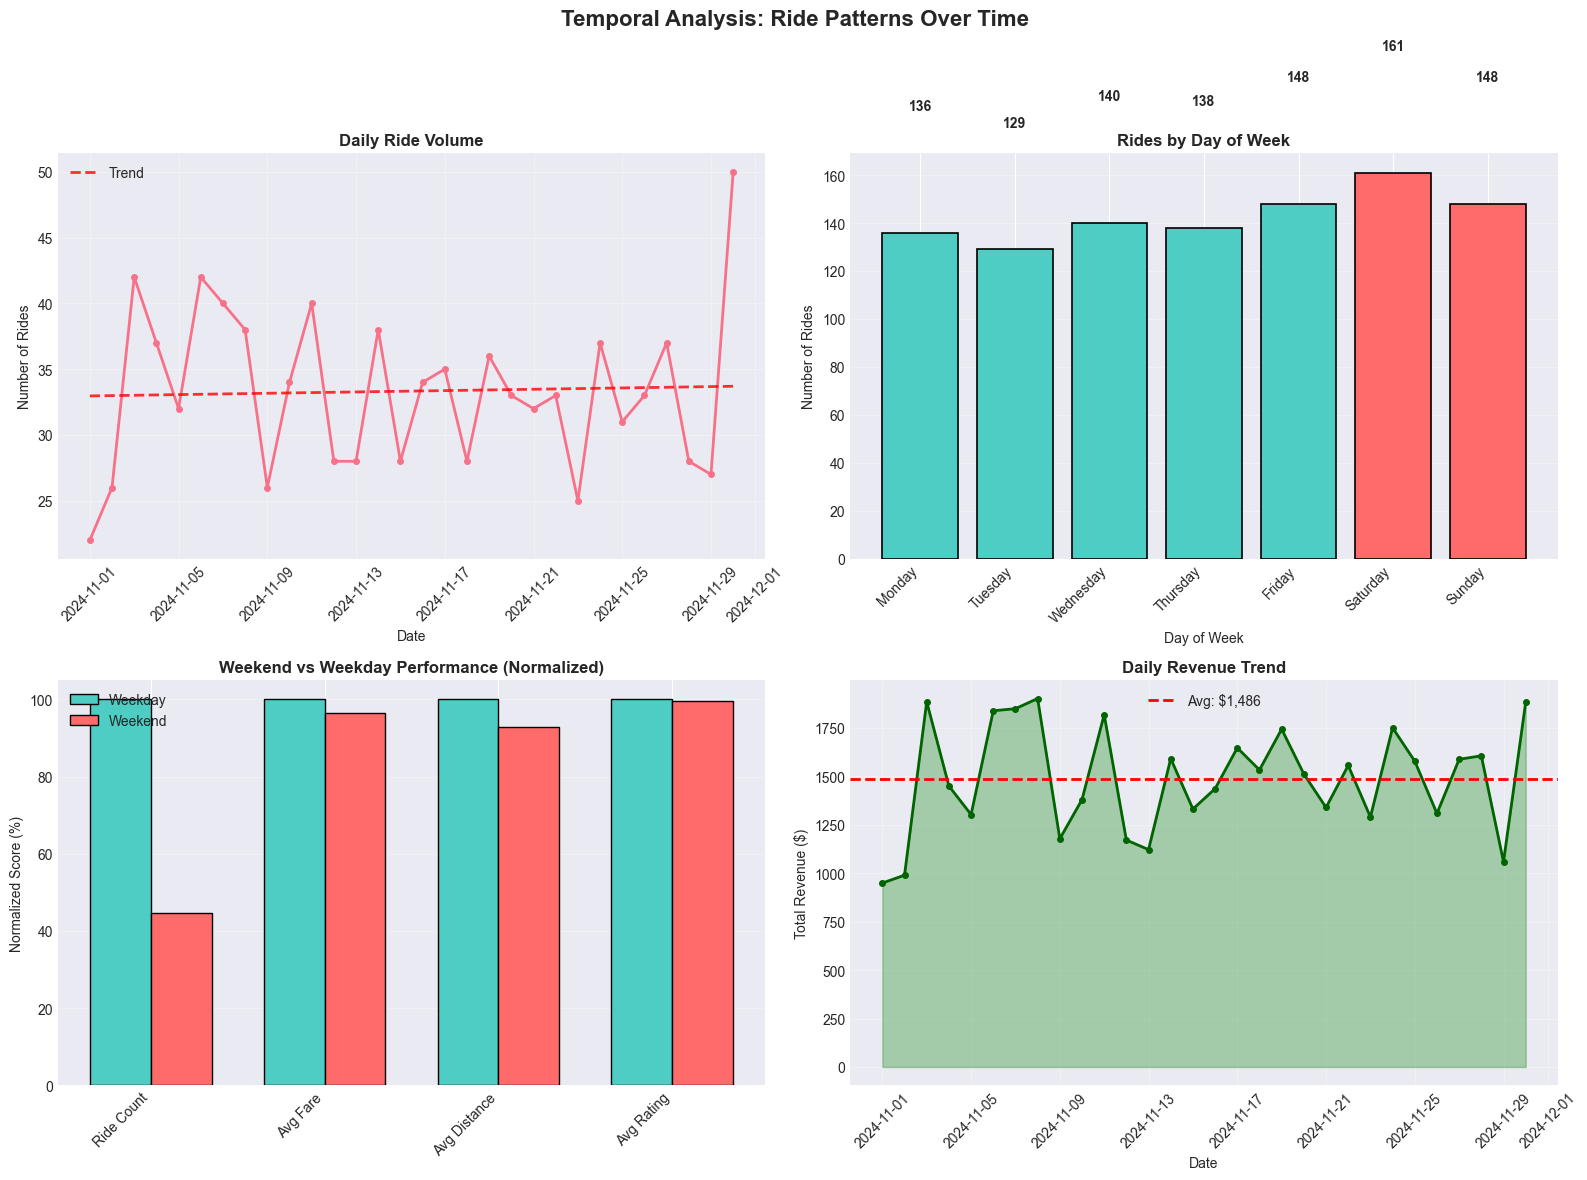


TEMPORAL INSIGHTS

1. Busiest day: Saturday with 161 rides
2. Slowest day: Tuesday with 129 rides
3. Weekend vs Weekday rides: 309 vs 691
4. Average daily rides: 33
5. Average daily revenue: $1,486.01


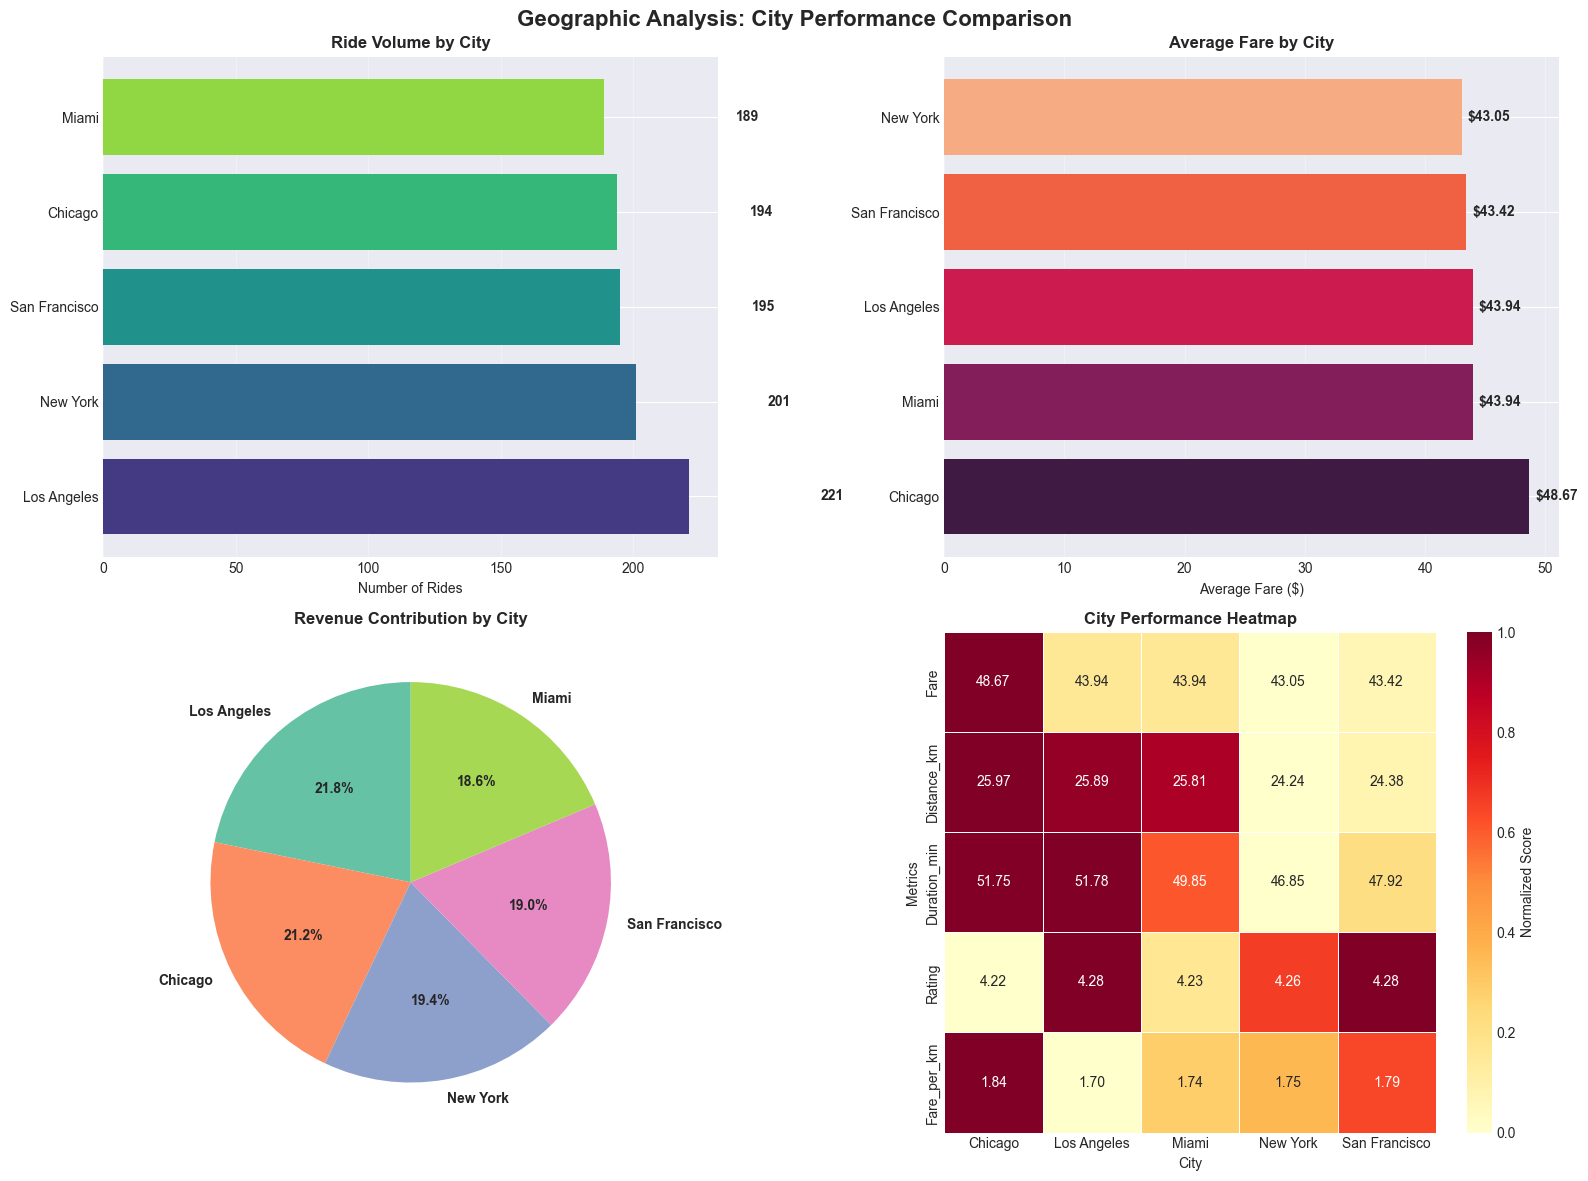


GEOGRAPHIC INSIGHTS

1. Highest volume city: Los Angeles with 221 rides
2. Highest revenue city: Los Angeles with $9,711.55
3. Highest avg fare: Chicago at $48.67
4. City market share (top 3):
   1. Los Angeles: $9,711.55 (21.8%)
   2. Chicago: $9,441.96 (21.2%)
   3. New York: $8,653.91 (19.4%)


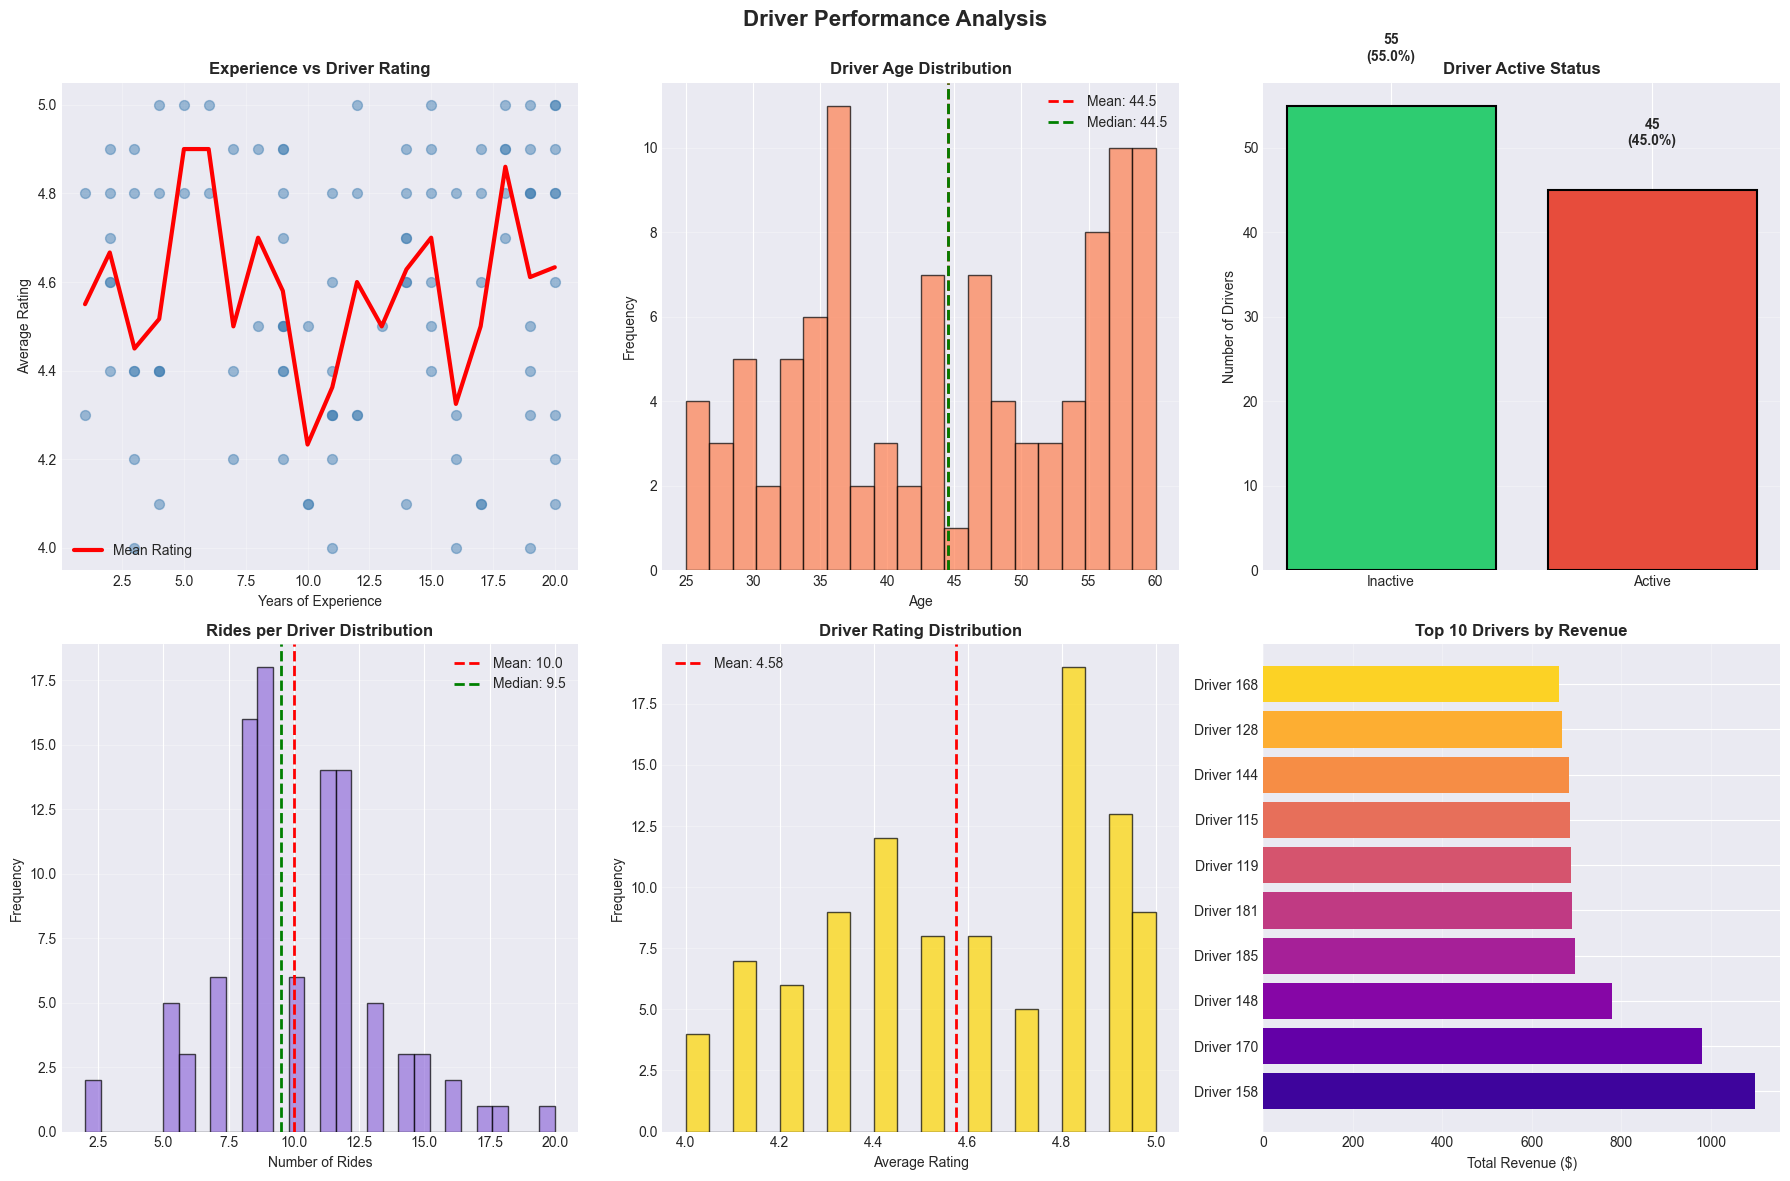


DRIVER PERFORMANCE INSIGHTS

1. Total active drivers: 45
2. Total inactive drivers: 55
3. Average rides per driver: 10.0
4. Most productive driver: 158 with 20 rides
5. Average driver rating: 4.58
6. Drivers with rating < 4.0: 0


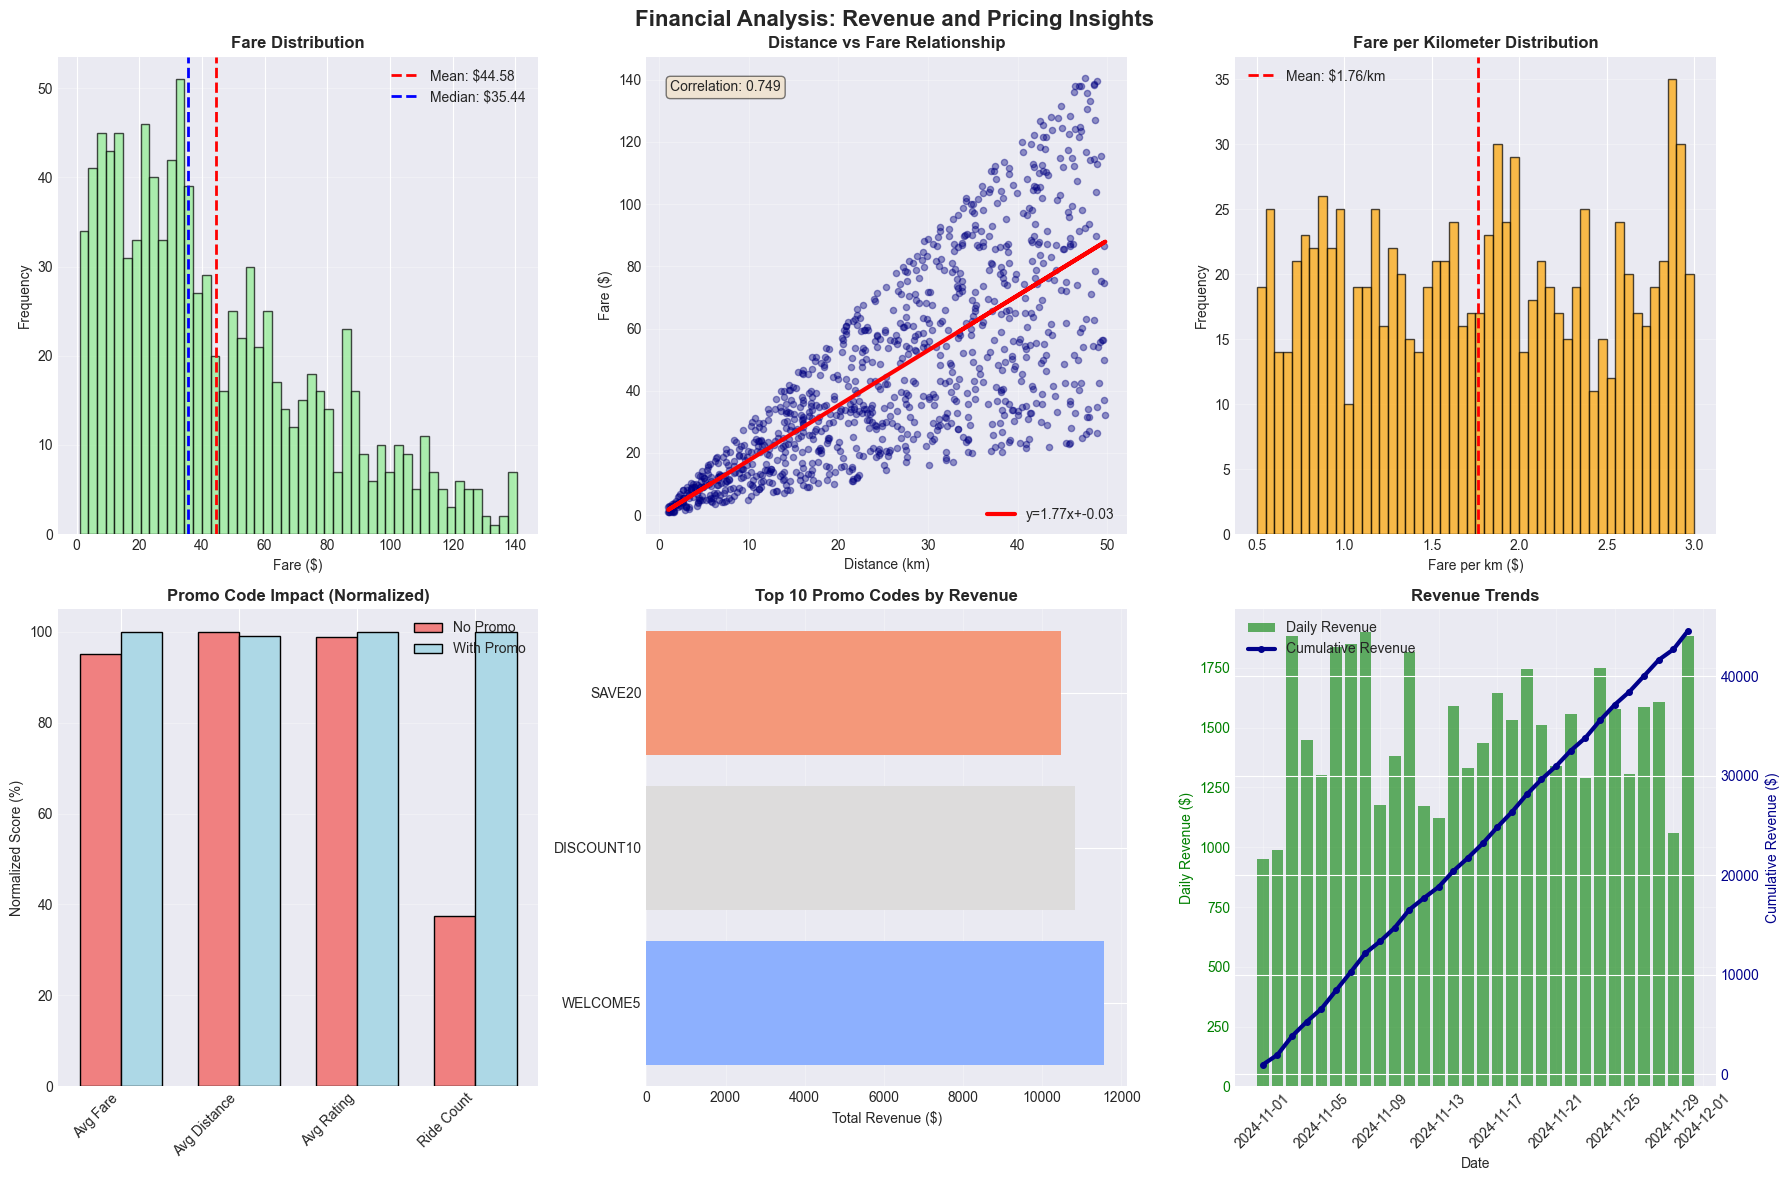


FINANCIAL INSIGHTS

1. Total revenue: $44,580.27
2. Average fare: $44.58
3. Average fare per km: $1.76
4. Rides with promo codes: 727 (72.7%)
5. Revenue from promo rides: $32,844.96
6. Average daily revenue: $1,486.01


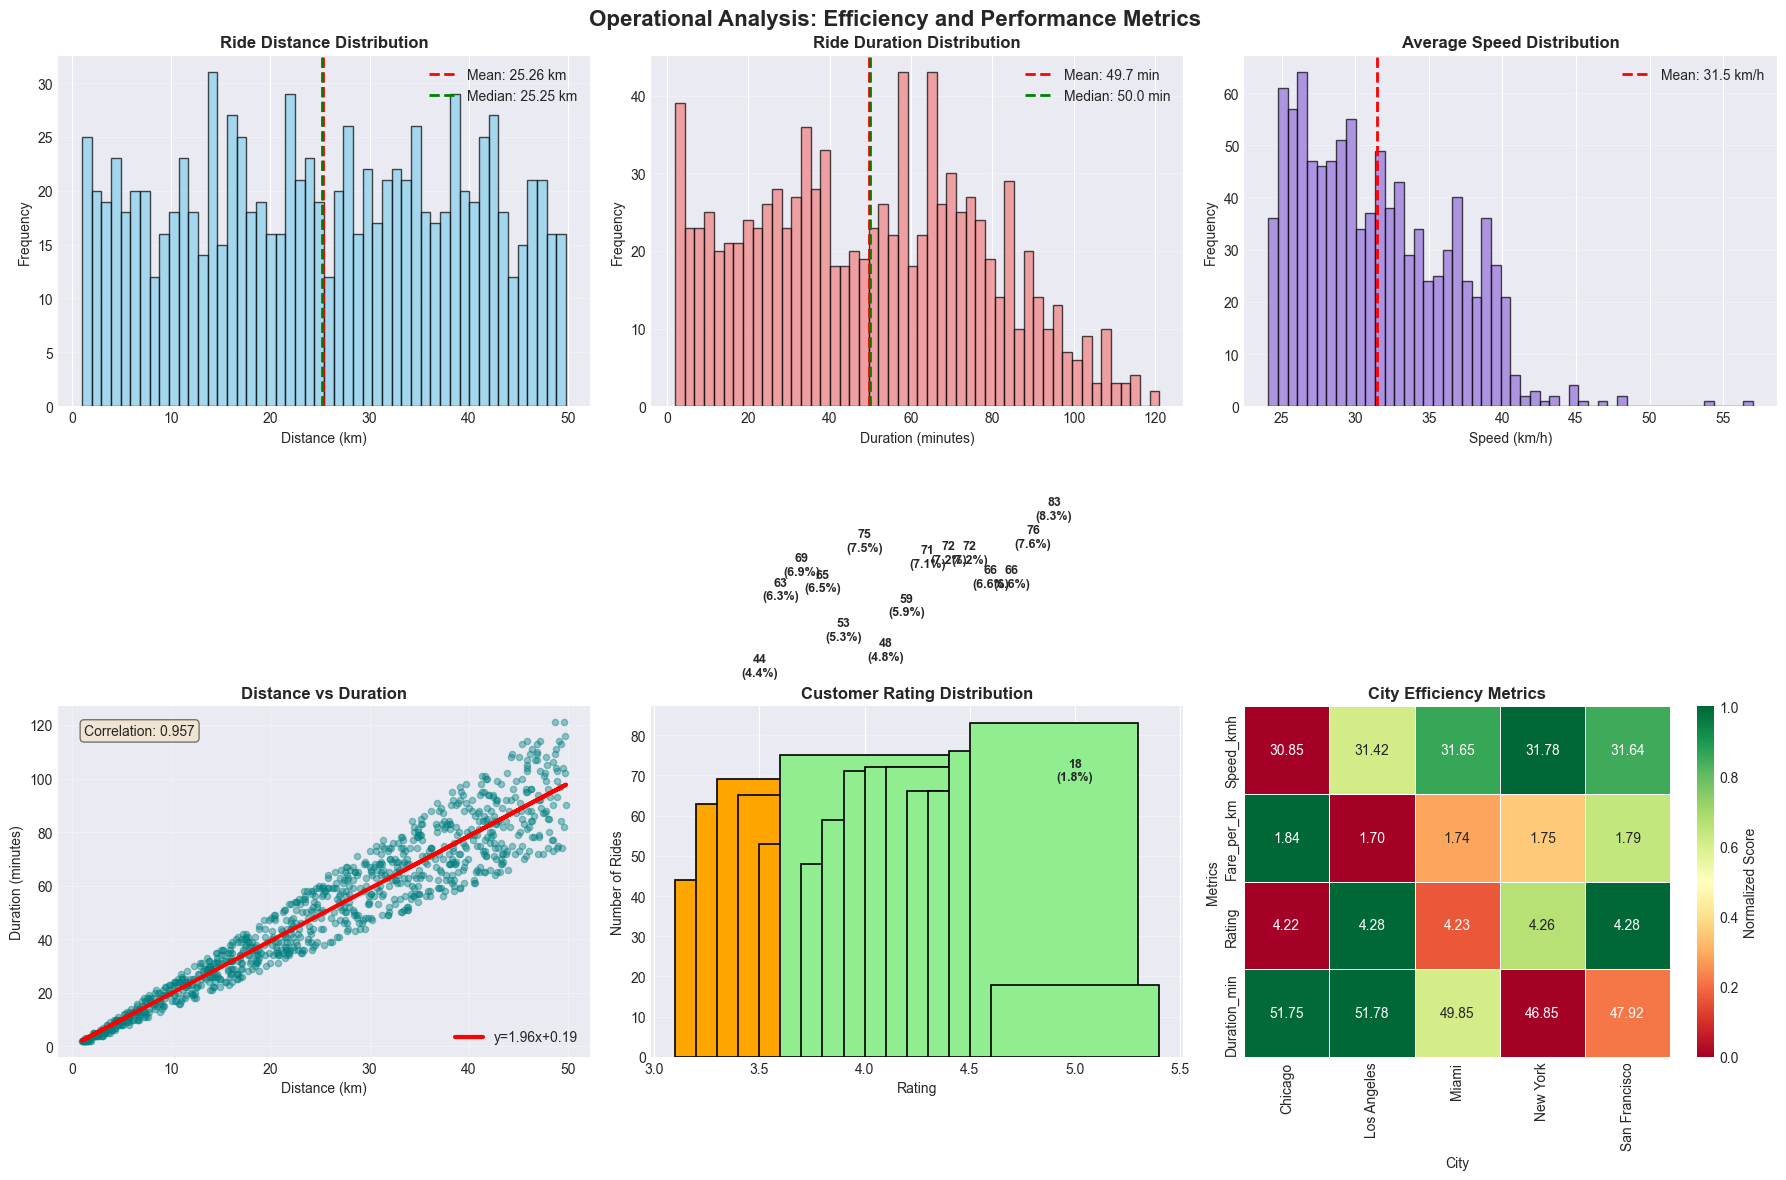


OPERATIONAL INSIGHTS

1. Average ride distance: 25.26 km
2. Average ride duration: 49.7 minutes
3. Average speed: 31.5 km/h
4. Average customer rating: 4.26/5.0
5. Rides rated 5 stars: 18 (1.8%)
6. Rides rated below 3 stars: 0 (0.0%)


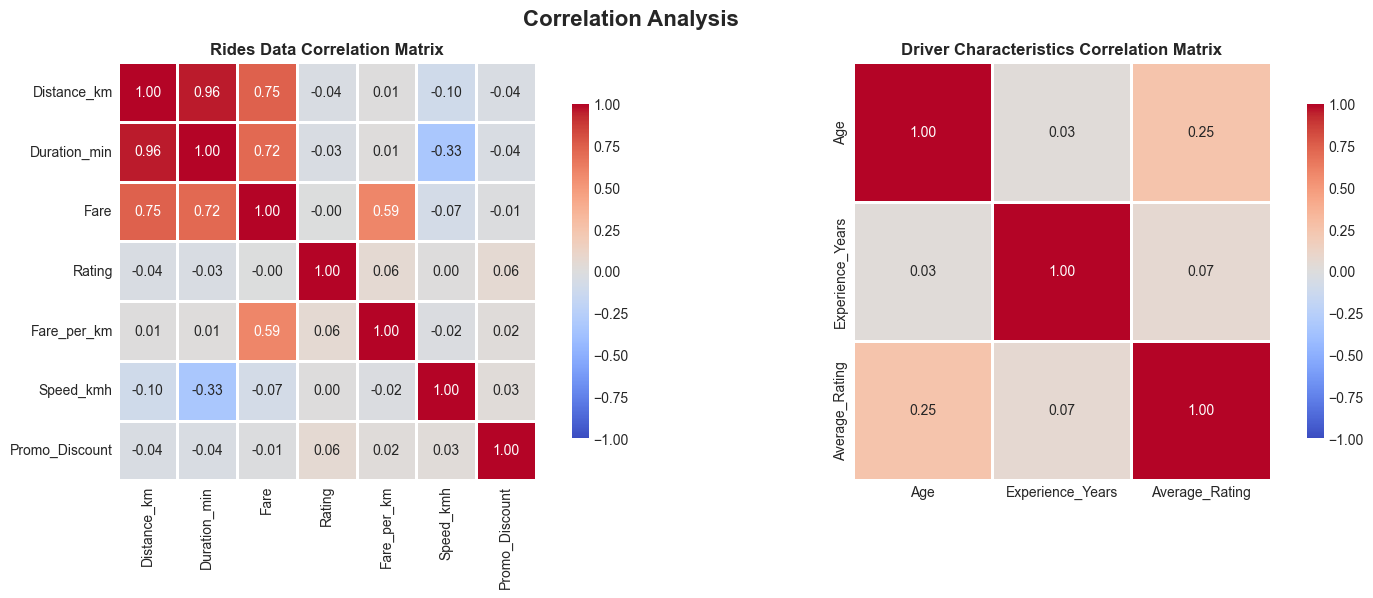


KEY CORRELATIONS

Rides Data:
1. Distance vs Fare: 0.749
2. Duration vs Fare: 0.717
3. Rating vs Fare: -0.002
4. Speed vs Rating: 0.000
5. Promo vs Rating: 0.059

Driver Data:
1. Experience vs Rating: 0.067
2. Age vs Experience: 0.027
3. Age vs Rating: 0.253

ADVANCED INSIGHTS & SEGMENTATION

1. DRIVER PERFORMANCE SEGMENTATION:
                     Total_Rides        Total_Revenue Avg_Ride_Rating
                           count   mean          mean            mean
Performance_Category                                                 
Low Performer                 44   8.09        307.44            4.25
Medium Performer              53  11.17        531.96            4.27
High Performer                 3  17.33        953.02            4.21

2. RIDE TYPE ANALYSIS:
                 Count  Avg_Fare  Avg_Rating  Avg_Fare_per_km
Ride_Type                                                    
Short (<5km)        89      5.52        4.32             1.84
Medium (5-15km)    195     17.58       

In [25]:
def run_full_eda(self):
    """Execute complete EDA workflow"""
    print("\n🚀 Starting Comprehensive EDA for CityRide...")
    print("=" * 80)
    
    # Run all analyses
    self.temporal_analysis()
    self.geographic_analysis()
    self.driver_performance_analysis()
    self.financial_analysis()
    self.operational_analysis()
    self.correlation_analysis()
    self.advanced_insights()
    self.generate_executive_summary()
    
    print("\n✅ EDA Complete! All visualizations saved.")
    print("📁 Generated files:")
    print("   - temporal_analysis.png")
    print("   - geographic_analysis.png")
    print("   - driver_performance_analysis.png")
    print("   - financial_analysis.png")
    print("   - operational_analysis.png")
    print("   - correlation_analysis.png")
    print("\n" + "=" * 80 + "\n")

# Assign method to class
CityRideEDA.run_full_eda = run_full_eda

# USAGE EXAMPLE
if __name__ == "__main__":
    # Initialize EDA with your data paths
    eda = CityRideEDA(rides_clean, drivers_clean, merged_clean)

    # Run complete EDA
    eda.run_full_eda()

---

<center>

## **4) Data Transformation & Data Warehouse Design**

</center>

### Justification for Data Warehouse Design Choice

For CityRide's analytical needs, we recommend implementing a **Star Schema** design. Here's our reasoning:

### Why Star Schema?

**1. Query Performance & Simplicity** <br>
Our primary users are mid-level managers who need fast, intuitive access to ride performance metrics. The star schema's denormalized structure minimizes joins, enabling quick query execution for dashboards and ad-hoc analysis. With only two source tables, the added complexity of a snowflake schema would provide minimal normalization benefits while increasing query complexity.

**2. Alignment with Business Questions**
CityRide's analytical needs center on a clear transactional event: the **ride**. This naturally becomes our fact table, with dimensions slicing the data by driver attributes, geographic location, time periods, and promotional campaigns. This structure directly supports questions like "What's our revenue by region this week?" or "How effective are our promotional discounts?"

**3. Scalability for Future Growth**
While our current dataset covers November 2024, the schema accommodates historical data accumulation. Separating the date dimension allows for time-intelligence calculations (week-over-week trends, seasonal patterns) as the platform matures. The regional enrichment in dim_city provides a foundation for geographic expansion analysis.

**4. Dashboard Optimization**
Tableau performs optimally with star schemas. The clear fact-dimension relationships translate directly to drag-and-drop analytics, reducing the technical barrier for business users. The single denormalized view (vw_rides_analysis) provides immediate access to all attributes without requiring users to understand table relationships.

### Design Decisions

| Decision | Rationale |
|----------|-----------|
| **Grain: One row per ride** | Preserves maximum analytical flexibility; aggregations can be performed at query time |
| **Conformed Date Dimension** | Enables consistent time-based analysis and future integration with other fact tables (e.g., support tickets, payments) |
| **Natural Keys in Dimensions** | Uses driver_id as PRIMARY KEY in dim_driver for simplicity; dim_city uses SERIAL key for flexibility |
| **Regional Enrichment** | Cities are mapped to US regions (Northeast, Midwest, South, West) to support geographic analysis without modifying fact table |
| **Promo Code with Discount Extraction** | Automatically extracts discount percentages from promo code text using regex; "NO_PROMO" serves as the default member for non-promotional rides |
| **Driver as Slowly Changing Dimension (Type 1)** | Given our snapshot data, we overwrite driver attributes; for production, Type 2 would track rating/status changes over time |

### **ER Diagram (Star Schema):**

In [28]:
from IPython.display import Image, display

display(Image(url='https://i.imghippo.com/files/Iwd1646nsU.png'))

### **SQL Transformation Scripts (PostgreSQL)**

In [27]:
"""

-- ============================================================
-- CITYRIDE DATA WAREHOUSE - STAR SCHEMA IMPLEMENTATION
-- PostgreSQL DDL and ETL Scripts
-- ============================================================

CREATE SCHEMA IF NOT EXISTS cityride_dw;
SET search_path TO cityride_dw;

-- ============================================================
-- STAGING TABLES (Landing zone for raw CSV data)
-- ============================================================

CREATE TABLE stg_rides (
    ride_id INTEGER,
    driver_id INTEGER,
    city VARCHAR(50),
    date DATE,
    distance_km DECIMAL(10,2),
    duration_min INTEGER,
    fare DECIMAL(10,2),
    rating DECIMAL(3,2),
    promo_code VARCHAR(30)
);

CREATE TABLE stg_drivers (
    driver_id INTEGER,
    name VARCHAR(100),
    age INTEGER,
    city VARCHAR(50),
    experience_years INTEGER,
    average_rating DECIMAL(3,2),
    active_status VARCHAR(20)
);

COPY stg_rides FROM 'C:/Program Files/PostgreSQL/17/data/Rides_Data.csv' CSV HEADER;
COPY stg_drivers FROM 'C:/Program Files/PostgreSQL/17/data/Drivers_Data.csv' CSV HEADER;

-- ============================================================
-- DIMENSION TABLES
-- ============================================================

CREATE TABLE dim_date (
    date_key INTEGER PRIMARY KEY,
    full_date DATE NOT NULL UNIQUE,
    day_of_month INTEGER NOT NULL,
    day_name VARCHAR(10) NOT NULL,
    day_of_week INTEGER NOT NULL,
    week_of_year INTEGER NOT NULL,
    month INTEGER NOT NULL,
    month_name VARCHAR(10) NOT NULL,
    quarter INTEGER NOT NULL,
    year INTEGER NOT NULL,
    is_weekend BOOLEAN NOT NULL
);

CREATE TABLE dim_city (
    city_key SERIAL PRIMARY KEY,
    city_name VARCHAR(50) NOT NULL UNIQUE,
    region VARCHAR(50),
    country VARCHAR(50)
);

CREATE TABLE dim_promo (
    promo_key SERIAL PRIMARY KEY,
    promo_code VARCHAR(30) NOT NULL UNIQUE,
    is_promotional BOOLEAN NOT NULL,
	discount_percent DECIMAL(5,4) NOT NULL
);

CREATE TABLE dim_driver (
    driver_id INTEGER PRIMARY KEY,
    driver_name VARCHAR(100) NOT NULL,
    age INTEGER,
    city VARCHAR(50),
    experience_years INTEGER,
    average_rating DECIMAL(3,2),
    active_status VARCHAR(20)
);

-- ============================================================
-- FACT TABLE
-- ============================================================

CREATE TABLE fact_rides (
    ride_id INTEGER PRIMARY KEY,
    driver_id INTEGER NOT NULL REFERENCES dim_driver(driver_id),
    date_key INTEGER NOT NULL REFERENCES dim_date(date_key),
    city_key INTEGER NOT NULL REFERENCES dim_city(city_key),
    promo_key INTEGER NOT NULL REFERENCES dim_promo(promo_key),
    distance_km DECIMAL(10,2),
    duration_min INTEGER,
    fare_usd DECIMAL(10,2),
    rating DECIMAL(3,2),
    fare_per_km DECIMAL(10,4),
    fare_per_min DECIMAL(10,4)
);

CREATE INDEX idx_fact_rides_driver ON fact_rides(driver_id);
CREATE INDEX idx_fact_rides_date ON fact_rides(date_key);
CREATE INDEX idx_fact_rides_city ON fact_rides(city_key);
CREATE INDEX idx_fact_rides_promo ON fact_rides(promo_key);

-- ============================================================
-- ETL: POPULATE DIMENSION TABLES
-- ============================================================

-- 1. Populate DIM_DATE (November 2024)
INSERT INTO dim_date (date_key, full_date, day_of_month, day_name, 
                      day_of_week, week_of_year, month, month_name, 
                      quarter, year, is_weekend)
SELECT 
    TO_CHAR(d, 'YYYYMMDD')::INTEGER AS date_key,
    d AS full_date,
    EXTRACT(DAY FROM d)::INTEGER,
    TRIM(TO_CHAR(d, 'Day')),
    EXTRACT(ISODOW FROM d)::INTEGER,
    EXTRACT(WEEK FROM d)::INTEGER,
    EXTRACT(MONTH FROM d)::INTEGER,
    TRIM(TO_CHAR(d, 'Month')),
    EXTRACT(QUARTER FROM d)::INTEGER,
    EXTRACT(YEAR FROM d)::INTEGER,
    EXTRACT(ISODOW FROM d) IN (6, 7)
FROM generate_series('2024-11-01'::DATE, '2024-11-30'::DATE, '1 day'::INTERVAL) AS d;

-- 2. Populate DIM_CITY with Region + Country
INSERT INTO dim_city (city_name, region, country)
SELECT DISTINCT 
    city AS city_name,

    CASE 
        -- Northeast
        WHEN city IN ('New York', 'Boston', 'Philadelphia', 'Baltimore', 'Washington') 
            THEN 'Northeast'

        -- Midwest
        WHEN city IN ('Chicago', 'Detroit', 'Cleveland', 'Columbus', 'Minneapolis') 
            THEN 'Midwest'

        -- South
        WHEN city IN ('Atlanta', 'Miami', 'Dallas', 'Houston', 'Charlotte', 'Orlando') 
            THEN 'South'

        -- West
        WHEN city IN ('Los Angeles', 'San Francisco', 'Seattle', 'Denver', 'Phoenix', 'Las Vegas') 
            THEN 'West'

        -- Default region
        ELSE 'Unknown'
    END AS region,

    'US' AS country   -- fixed for all cities

FROM stg_rides
WHERE city IS NOT NULL
ON CONFLICT (city_name) DO UPDATE SET
    region = EXCLUDED.region,
    country = EXCLUDED.country;


-- 3. Populate DIM_PROMO
INSERT INTO dim_promo (promo_code, is_promotional, discount_percent)
SELECT DISTINCT
    CASE 
        WHEN promo_code IS NULL OR TRIM(promo_code) = '' THEN 'NO_PROMO'
        ELSE promo_code
    END AS promo_code_clean,

    CASE 
        WHEN promo_code IS NULL OR TRIM(promo_code) = '' OR promo_code = 'NO_PROMO' 
            THEN FALSE
        ELSE TRUE
    END AS is_promotional,

    CASE 
        WHEN promo_code ~ '\d+' 
            THEN regexp_replace(promo_code, '\D', '', 'g')::DECIMAL / 100.0
        ELSE 0
    END AS discount_percent

FROM stg_rides
ON CONFLICT (promo_code) DO UPDATE SET
    is_promotional = EXCLUDED.is_promotional,
    discount_percent = EXCLUDED.discount_percent;



-- 4. Populate DIM_DRIVER
INSERT INTO dim_driver (driver_id, driver_name, age, city, experience_years, 
                        average_rating, active_status)
SELECT 
    driver_id,
    name,
    age,
    city,
    experience_years,
    average_rating,
    active_status
FROM stg_drivers
ON CONFLICT (driver_id) DO UPDATE SET
    driver_name = EXCLUDED.driver_name,
    age = EXCLUDED.age,
    city = EXCLUDED.city,
    experience_years = EXCLUDED.experience_years,
    average_rating = EXCLUDED.average_rating,
    active_status = EXCLUDED.active_status;

-- ============================================================
-- ETL: POPULATE FACT TABLE
-- ============================================================

INSERT INTO fact_rides (ride_id, driver_id, date_key, city_key, promo_key,
                        distance_km, duration_min, fare_usd, rating,
                        fare_per_km, fare_per_min)
SELECT 
    r.ride_id,
    r.driver_id,
    TO_CHAR(r.date, 'YYYYMMDD')::INTEGER,
    c.city_key,
    p.promo_key,
    r.distance_km,
    r.duration_min,
    r.fare,
    r.rating,
    CASE WHEN r.distance_km > 0 
         THEN ROUND(r.fare / r.distance_km, 4) 
         ELSE NULL END,
    CASE WHEN r.duration_min > 0 
         THEN ROUND(r.fare / r.duration_min, 4) 
         ELSE NULL END
FROM stg_rides r
JOIN dim_driver d ON r.driver_id = d.driver_id
JOIN dim_city c ON r.city = c.city_name
JOIN dim_promo p 
    ON COALESCE(NULLIF(TRIM(r.promo_code), ''), 'NO_PROMO') = p.promo_code
ON CONFLICT (ride_id) DO NOTHING;

-- ============================================================
-- ANALYTICAL VIEW (For Tableau)
-- ============================================================

CREATE OR REPLACE VIEW vw_rides_analysis AS
SELECT 
    f.ride_id,
    dt.full_date,
    dt.day_name,
    dt.day_of_week,
    dt.week_of_year,
    dt.is_weekend,
    c.city_name AS ride_city,
    c.region,
    c.country,
    d.driver_id,
    d.driver_name,
    d.age AS driver_age,
    d.city AS driver_city,
    d.experience_years,
    d.average_rating AS driver_avg_rating,
    d.active_status,
    p.promo_code,
    p.is_promotional,
	p.discount_percent,
    f.distance_km,
    f.duration_min,
    f.fare_usd,
    f.rating AS ride_rating,
    f.fare_per_km,
    f.fare_per_min
FROM fact_rides f
JOIN dim_date dt ON f.date_key = dt.date_key
JOIN dim_city c ON f.city_key = c.city_key
JOIN dim_driver d ON f.driver_id = d.driver_id
JOIN dim_promo p ON f.promo_key = p.promo_key;

"""

"\n\n-- ============================================================\n-- CITYRIDE DATA WAREHOUSE - STAR SCHEMA IMPLEMENTATION\n-- PostgreSQL DDL and ETL Scripts\n-- ============================================================\n\nCREATE SCHEMA IF NOT EXISTS cityride_dw;\nSET search_path TO cityride_dw;\n\n-- ============================================================\n-- STAGING TABLES (Landing zone for raw CSV data)\n-- ============================================================\n\nCREATE TABLE stg_rides (\n    ride_id INTEGER,\n    driver_id INTEGER,\n    city VARCHAR(50),\n    date DATE,\n    distance_km DECIMAL(10,2),\n    duration_min INTEGER,\n    fare DECIMAL(10,2),\n    rating DECIMAL(3,2),\n    promo_code VARCHAR(30)\n);\n\nCREATE TABLE stg_drivers (\n    driver_id INTEGER,\n    name VARCHAR(100),\n    age INTEGER,\n    city VARCHAR(50),\n    experience_years INTEGER,\n    average_rating DECIMAL(3,2),\n    active_status VARCHAR(20)\n);\n\nCOPY stg_rides FROM 'C:/Program Files

### **Data Warehouse Design Overview**

Our star schema transforms CityRide's operational data into an analytics-ready structure that directly supports the insights discovered in our EDA phase.

### Star Schema Components

| Component | Description | Connection to EDA Findings |
|-----------|-------------|---------------------------|
| **fact_rides** | Central fact table with one row per ride | Stores all 6 ride metrics we analyzed: distance, duration, fare, rating, plus derived efficiency measures (fare_per_km, fare_per_min) |
| **dim_date** | Calendar dimension for temporal analysis | Supports our weekday/weekend comparisons and daily trend analysis with pre-calculated weekend flags |
| **dim_driver** | Driver attributes and characteristics | Preserves driver demographics (age, experience, ratings) enabling the driver performance segmentation we explored |
| **dim_city** | Geographic dimension with regional mapping | Enriched with US regions (Northeast, Midwest, South, West) to support the city-level analysis and market comparisons from our geographic EDA |
| **dim_promo** | Promotional campaign tracking | Captures promo codes with extracted discount percentages, enabling analysis of promotional effectiveness we identified as a business priority |

### Design Rationale: From EDA to Data Warehouse

Our EDA revealed several key analytical patterns that influenced the warehouse design:

**1. Temporal Patterns Matter**
The EDA showed distinct weekday vs. weekend ride behavior and daily volume fluctuations. The **dim_date** dimension pre-calculates weekend flags and organizes dates hierarchically (day → week → month → quarter) to support time-based trend analysis efficiently.

**2. Geographic Performance Varies**
We discovered significant variation in ride volume, revenue, and service quality across cities. The **dim_city** dimension maps each city to its US region, enabling both city-level drill-downs and regional rollups without query-time calculations.

**3. Promotional Impact Needs Measurement**
While the EDA identified promotional rides, the **dim_promo** dimension enhances this by extracting discount percentages from promo code text using regex patterns. This allows precise ROI analysis of marketing campaigns. Rides without promotions are standardized as 'NO_PROMO' for consistent filtering.

**4. Driver Metrics Drive Service Quality**
The driver analysis revealed correlations between experience, ratings, and ride performance. The **dim_driver** stores all raw driver attributes, allowing analysts to create custom segments (junior/senior, high/low rated) at query time based on evolving business needs.

**5. Efficiency Metrics Are Critical**
The EDA examined fare efficiency through various lenses. The **fact_rides** table pre-calculates fare_per_km and fare_per_min to avoid repetitive division operations in dashboards, improving query performance for the pricing analytics we identified as important.

### Analytical View for Tableau

**vw_rides_analysis** serves as the primary reporting view by fully denormalizing the star schema:

- **Temporal Dimensions**: full_date, day_name, day_of_week, week_of_year, is_weekend
- **Geographic Dimensions**: ride_city, region, country  
- **Driver Dimensions**: driver_id, driver_name, driver_age, driver_city, experience_years, driver_avg_rating, active_status
- **Promotional Dimensions**: promo_code, is_promotional, discount_percent
- **Ride Metrics**: distance_km, duration_min, fare_usd, ride_rating, fare_per_km, fare_per_min

This single view provides instant access to all the metrics and dimensions we analyzed during EDA, eliminating the need for business users to understand complex join logic while maintaining the flexibility to slice data by any combination of time, geography, driver characteristics, or promotional status.

---